In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import eda, transform
import new_or_used

## Data load

In [2]:
X_train, y_train, X_test, y_test = new_or_used.build_dataset()

In [3]:
# Using Pandas Dataframe structure to ease EDA

X_train = pd.json_normalize(X_train)

## EDA and Data Wrangling

#### Basic summary

In [4]:
eda.get_basic_dataset_summary(X_train, y_train)

X_train has 90000 rows and 56 columns
y_train has 90000 rows

Columns in train dataset with any null values: ['warranty', 'parent_item_id', 'official_store_id', 'differential_pricing', 'original_price', 'video_id', 'catalog_product_id', 'subtitle', 'shipping.methods', 'shipping.dimensions', 'shipping.free_methods']


#### Distribution of target in the train dataset

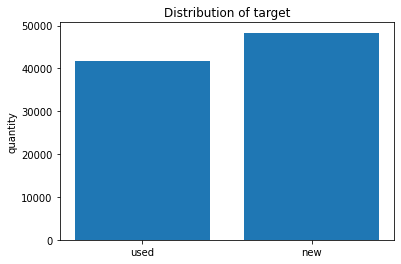

<Figure size 2304x1728 with 0 Axes>

In [5]:
eda.plot_target(y_train)

#### Data types and non-null count by column (train dataset)

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 56 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   warranty                          35243 non-null  object 
 1   sub_status                        90000 non-null  object 
 2   condition                         90000 non-null  object 
 3   deal_ids                          90000 non-null  object 
 4   base_price                        90000 non-null  float64
 5   non_mercado_pago_payment_methods  90000 non-null  object 
 6   seller_id                         90000 non-null  int64  
 7   variations                        90000 non-null  object 
 8   site_id                           90000 non-null  object 
 9   listing_type_id                   90000 non-null  object 
 10  price                             90000 non-null  float64
 11  attributes                        90000 non-null  object 
 12  buyi

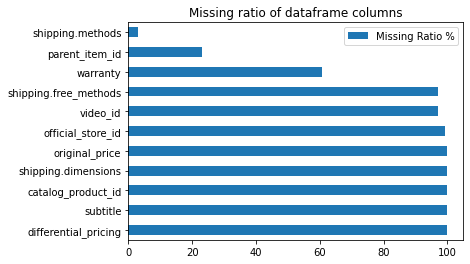

In [7]:
eda.plot_nas(X_train)

In [8]:
# Drop columns with more than 80% of nan values

X_train = X_train.drop([
    'shipping.free_methods', 'video_id',
    'official_store_id', 'original_price',
    'shipping.dimensions', 'catalog_product_id',
    'subtitle', 'differential_pricing'], axis=1)

#### Possible datetime columns

In [9]:
# date_created and last_updated seem to be datetime columns 

X_train.loc[:3, ['date_created', 'last_updated']]

,date_created,last_updated
0,2015-09-05T20:42:53.000Z,2015-09-05T20:42:58.000Z
1,2015-09-26T18:08:30.000Z,2015-09-26T18:08:34.000Z
2,2015-09-09T23:57:07.000Z,2015-09-09T23:57:10.000Z
3,2015-09-28T18:47:56.000Z,2015-10-05T16:03:50.306Z


Let's convert those columns to datetime and check the frequency of data over time

In [10]:
dt_cols = ['date_created', 'last_updated']
X_train[dt_cols] = (
    X_train[dt_cols].apply(pd.to_datetime, errors='coerce'))

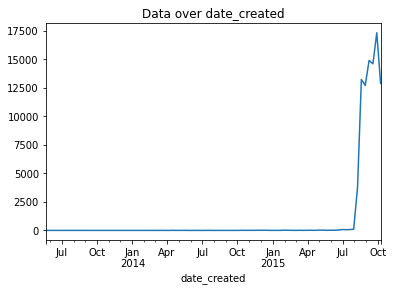

In [11]:
eda.plot_over_time(X_train,
                   time_key='date_created',
                   freq='10D',
                   title='Data dist over date_created')

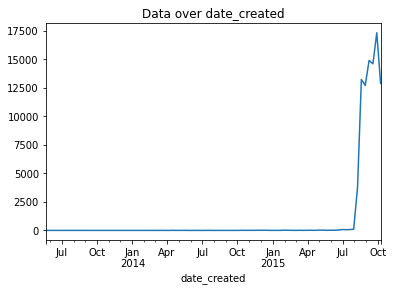

In [12]:
eda.plot_over_time(X_train,
                   time_key='last_updated',
                   freq='10D',
                   title='Data dist over last_updated')

For simplicity, let's remove data from before august 2015

In [13]:
X_train = X_train[
    X_train['date_created'].dt.date >=
    pd.Timestamp('2015-08-01').date()].reset_index(drop=True)

And update y_train using the `condition` column

In [14]:
y_train = X_train['condition']

Let's see the difference between creation time and update time

<AxesSubplot:>

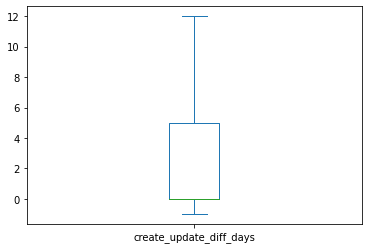

In [15]:
X_train['create_update_diff_days'] = (
    X_train['last_updated'] - X_train['date_created']).dt.days

X_train['create_update_diff_days'].plot(kind='box',
                                        showfliers=False)

Descriptive statistics for the difference in days between date_created and last_updated

In [16]:
X_train['create_update_diff_days'].describe()

count    89433.000000
mean         6.096810
std         12.316432
min         -1.000000
25%          0.000000
50%          0.000000
75%          5.000000
max         74.000000
Name: create_update_diff_days, dtype: float64

For some reason, some rows have last_updated dated seconds before date_created

In [17]:
X_train[X_train['create_update_diff_days'] == -1][['date_created', 'last_updated']].head()

,date_created,last_updated
1608,2015-08-26 01:40:23+00:00,2015-08-26 01:40:22+00:00
1641,2015-09-07 17:39:07+00:00,2015-09-07 17:39:06+00:00
26702,2015-08-29 12:43:37+00:00,2015-08-29 12:43:36+00:00
30177,2015-09-07 13:03:37+00:00,2015-09-07 13:03:36+00:00
35250,2015-08-30 20:00:13+00:00,2015-08-30 20:00:12+00:00


Let's just make those negative numbers become 0 for simplicity

In [18]:
X_train['create_update_diff_days'] = np.where(
    X_train.create_update_diff_days < 0,
    0,
    X_train.create_update_diff_days)

#### Descriptive statistics for numeric columns

In [19]:
X_train.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,base_price,seller_id,price,stop_time,initial_quantity,start_time,sold_quantity,available_quantity,create_update_diff_days
count,89433.00,89433.00,89433.00,89433.00,89433.00,89433.00,89433.00,89433.00,89433.00
mean,57013.50,5488189256.77,57013.61,1447639580195.71,34.93,1442472553049.06,2.29,34.69,6.10
std,9118203.34,2586463076.37,9118203.34,2801296401.14,420.99,1511701477.47,33.73,420.72,12.32
min,0.84,1000319478.00,0.84,1444823497000.00,1.00,1438461115000.00,0.00,1.00,0.00
25%,90.00,3184874639.00,90.00,1446316596000.00,1.00,1441168169000.00,0.00,1.00,0.00
50%,250.00,5514660848.00,250.00,1447674965000.00,1.00,1442538339000.00,0.00,1.00,0.00
75%,800.00,7704929703.00,800.00,1448935199000.00,2.00,1443803151000.00,0.00,2.00,5.00
max,2222222222.00,9999852737.00,2222222222.00,1730732151000.00,9999.00,1444900470000.00,6065.00,9999.00,74.00


- The column `seller_id` should not be numeric
- What's the difference between `base_price` and `price`?
- What do `start_time` and `stop_time` mean?

In [20]:
# Converting seller_id to string

X_train['seller_id'] = X_train['seller_id'].astype(object)

#### Categorical values for non-numeric columns

In [21]:
eda.print_categorical_values(X_train)

Column: warranty
Feature with high cardinality (more than 20 categories)

Column: condition
Possible values: ['new' 'used']

Column: seller_id
Feature with high cardinality (more than 20 categories)

Column: site_id
Possible values: ['MLA']

Column: listing_type_id
Possible values: ['bronze' 'silver' 'free' 'gold_special' 'gold' 'gold_premium' 'gold_pro']

Column: buying_mode
Possible values: ['buy_it_now' 'classified' 'auction']

Column: listing_source
Possible values: ['']

Column: parent_item_id
Feature with high cardinality (more than 20 categories)

Column: category_id
Feature with high cardinality (more than 20 categories)

Column: last_updated
Feature with high cardinality (more than 20 categories)

Column: international_delivery_mode
Possible values: ['none']

Column: id
Feature with high cardinality (more than 20 categories)

Column: currency_id
Possible values: ['ARS' 'USD']

Column: thumbnail
Feature with high cardinality (more than 20 categories)

Column: title
Feature with

Let's drop columns with irrelevant information

In [22]:
X_train = X_train.drop(['site_id', 'listing_source',
                        'international_delivery_mode',
                        'seller_address.country.name',
                        'seller_address.country.id'], axis=1)

### Unhashable type columns

`sub_status`,`deal_ids`, `non_mercado_pago_payment_methods`, `variations`, `attributes`, `tags`, `coverage_areas`, `descriptions`, `pictures`, `shipping.methods`, `shipping.tags`

#### deal_ids

In [23]:
X_train['deal_ids'].value_counts().head()

[]         89221
[MOSH6]       52
[WGPLA]       34
[ABQ1I]       27
[15H9O]       26
Name: deal_ids, dtype: int64

- Let's take it out of the lists

In [24]:
X_train['deal_ids'] = X_train['deal_ids'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

#### non_mercado_pago_payment_methods

- Each row is a list of json

In [25]:
X_train['non_mercado_pago_payment_methods'].loc[:3]

0    [{'description': 'Transferencia bancaria', 'id...
1    [{'description': 'Transferencia bancaria', 'id...
2    [{'description': 'Transferencia bancaria', 'id...
3    [{'description': 'Transferencia bancaria', 'id...
Name: non_mercado_pago_payment_methods, dtype: object

- If we normalize it, we will get the following combination of values

In [26]:
pd.json_normalize(
    X_train[['non_mercado_pago_payment_methods']]
    .explode('non_mercado_pago_payment_methods')
    .non_mercado_pago_payment_methods.values).value_counts()

description               id     type
Efectivo                  MLAMO  G       60242
Transferencia bancaria    MLATB  G       46220
Tarjeta de crédito        MLAOT  N       22088
Acordar con el comprador  MLAWC  G        7157
Giro postal               MLAWT  G        1486
MercadoPago               MLAMP  G         645
Visa                      MLAVS  C         622
MasterCard                MLAMC  C         569
Contra reembolso          MLACD  G         568
Visa Electron             MLAVE  D         562
Mastercard Maestro        MLAMS  D         555
American Express          MLAAM  C         530
Cheque certificado        MLABC  G         412
Diners                    MLADC  C         412
dtype: int64

- Since each description corresponds to a single id and type, we can use id as our category.

In [27]:
X_train['non_mercado_pago_payment_methods'] = (
    X_train['non_mercado_pago_payment_methods']
    .apply(lambda x: [d.get('id') for d in x]))

In [28]:
X_train['non_mercado_pago_payment_methods'].head(5)

0    [MLATB, MLAWC, MLAMO]
1           [MLATB, MLAMO]
2    [MLATB, MLAOT, MLAMO]
3    [MLATB, MLAOT, MLAMO]
4    [MLATB, MLAWC, MLAMO]
Name: non_mercado_pago_payment_methods, dtype: object

- Since each row can have multiple payment methods, let's just create dummies for each category.

In [29]:
X_train = eda.one_hot_encode_list(X_train, 'non_mercado_pago_payment_methods')

#### sub_status

In [30]:
X_train['sub_status'].head()

0    []
1    []
2    []
3    []
4    []
Name: sub_status, dtype: object

- Again with lists, let's just explode them with the first element.

In [31]:
X_train['sub_status'] = X_train['sub_status'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

#### variations

In [32]:
X_train['variations'].loc[:5]

0    []
1    []
2    []
3    []
4    []
5    []
Name: variations, dtype: object

In [33]:
X_train.loc[X_train['variations'].str.len() != 0, ['variations']].iloc[:5]

,variations
6,[{'attribute_combinations': [{'value_id': '920...
9,[{'attribute_combinations': [{'value_id': '920...
13,[{'attribute_combinations': [{'value_id': '920...
29,[{'attribute_combinations': [{'value_id': '920...
75,[{'attribute_combinations': [{'value_id': '920...


- Again a json, maybe normalize it?

In [34]:
pd.json_normalize(
    X_train.loc[X_train['variations'].str.len() != 0, ['variations']]
    .explode('variations')
    .variations.values).head(5)

,attribute_combinations,seller_custom_field,picture_ids,sold_quantity,available_quantity,id,price
0,"[{'value_id': '92012', 'name': 'Color Primario...",None,"[472901-MLA20442937232_102015, 509801-MLA20442...",0,1,9742952789,180.0
1,"[{'value_id': '92021', 'name': 'Color Primario...",None,"[22802-MLA20237759642_022015, 22826-MLA2023775...",1,1,9720380234,120.0
2,"[{'value_id': '92000', 'name': 'Color Primario...",None,"[908601-MLA20391431364_082015, 817701-MLA20391...",0,1,9338152892,450.0
3,"[{'value_id': '92013', 'name': 'Color Primario...",None,"[21897-MLA20219050871_122014, 21826-MLA2021905...",1,2,9391988875,590.0
4,"[{'value_id': '92013', 'name': 'Color Primario...",None,"[21897-MLA20219050871_122014, 21826-MLA2021905...",0,2,9391988878,590.0


- Even normalizing, the structure is too complex. Let's simplify using the number of variations.

In [35]:
X_train['variations_count'] = X_train['variations'].apply(lambda x: len(x))
X_train = X_train.drop(['variations'], axis=1)

#### attributes

- `attribute` is a list of dictionaries. Too complex to deal with.
Let's use a boolean indicating if there are attributes or not.

In [36]:
pd.json_normalize(
    X_train.loc[X_train['attributes'].str.len() != 0, ['attributes']]
    .explode('attributes')
    .attributes.values).head(3)

,value_id,attribute_group_id,name,value_name,attribute_group_name,id
0,,DFLT,Número de pieza,37123,Otros,PART_NUMBER
1,female,DFLT,Género,Mujer,Otros,GENDER
2,Season-Spring-Summer,FIND,Season,Spring-Summer,Ficha técnica,Season


In [37]:
X_train['has_attributes'] = X_train['attributes'].apply(lambda x: 1 if len(x) > 0 else 0)
X_train = X_train.drop(['attributes'], axis=1)

#### tags

In [38]:
X_train.tags.value_counts().head(3)

[dragged_bids_and_visits]                            65262
[]                                                   22063
[good_quality_thumbnail, dragged_bids_and_visits]     1165
Name: tags, dtype: int64

- The same we did with `non_mercado_pago_payment_method`

In [39]:
X_train = eda.one_hot_encode_list(X_train, 'tags')

#### coverage_areas

In [40]:
X_train.coverage_areas.value_counts()

[]    89433
Name: coverage_areas, dtype: int64

- Every row has an empty list, let's just drop it.

In [41]:
X_train = X_train.drop(['coverage_areas'], axis=1)

#### descriptions

- `descriptions` are too unique to use, let's just drop it.

In [42]:
X_train = X_train.drop(['descriptions'], axis=1)

#### pictures

- We can't use the data from pictures per se, but we could instead count have many pictures each row has.

In [43]:
X_train['pictures_amnt'] = X_train['pictures'].apply(lambda x: len(x))
X_train = X_train.drop(['pictures'], axis=1)

#### shipping.methods

In [44]:
X_train['shipping.methods'].value_counts()

[]    86762
Name: shipping.methods, dtype: int64

- Just drop it.

In [45]:
X_train = X_train.drop(['shipping.methods'], axis=1)

#### shipping.tags

In [46]:
X_train['shipping.tags'].value_counts()

[]                               89375
[relisted_with_modifications]       50
[free_method_upgraded]               8
Name: shipping.tags, dtype: int64

- Most are empty. Just drop it.

In [47]:
X_train = X_train.drop(['shipping.tags'], axis=1)

### Columns with high cardinality

To make it easier, let's just drop every high cardinality column for now

`warranty`, `seller_id`, `parent_item_id`, `category_id`, `id`, `thumbnail`, `title`, `secure_thumbnail`, `permalink`, `seller_address.state.name`, `seller_address.state.id`, `seller_address.city.name`, `seller_address.city.id`

In [48]:
X_train = X_train.drop(['warranty', 'seller_id',
                        'parent_item_id', 'category_id',
                        'id', 'thumbnail', 'title',
                        'secure_thumbnail', 'permalink',
                        'seller_address.state.name',
                        'seller_address.state.id',
                        'seller_address.city.name',
                         'seller_address.city.id'], axis=1)

## Dataframe post early wrangling

In [49]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89433 entries, 0 to 89432
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   sub_status               888 non-null    object             
 1   condition                89433 non-null  object             
 2   deal_ids                 212 non-null    object             
 3   base_price               89433 non-null  float64            
 4   listing_type_id          89433 non-null  object             
 5   price                    89433 non-null  float64            
 6   buying_mode              89433 non-null  object             
 7   last_updated             89433 non-null  datetime64[ns, UTC]
 8   accepts_mercadopago      89433 non-null  bool               
 9   currency_id              89433 non-null  object             
 10  automatic_relist         89433 non-null  bool               
 11  date_created             894

- Since sub_status and deal_ids are mostly nan, let's drop them

In [50]:
X_train = X_train.drop(['sub_status', 'deal_ids'], axis=1)

- Let's replace start_time and stop_time with the difference between them

In [51]:
X_train['diff_start_stop_time'] = X_train['start_time'] - X_train['stop_time']
X_train = X_train.drop(['start_time', 'stop_time'], axis=1)

### Do the categories hold stability over time?

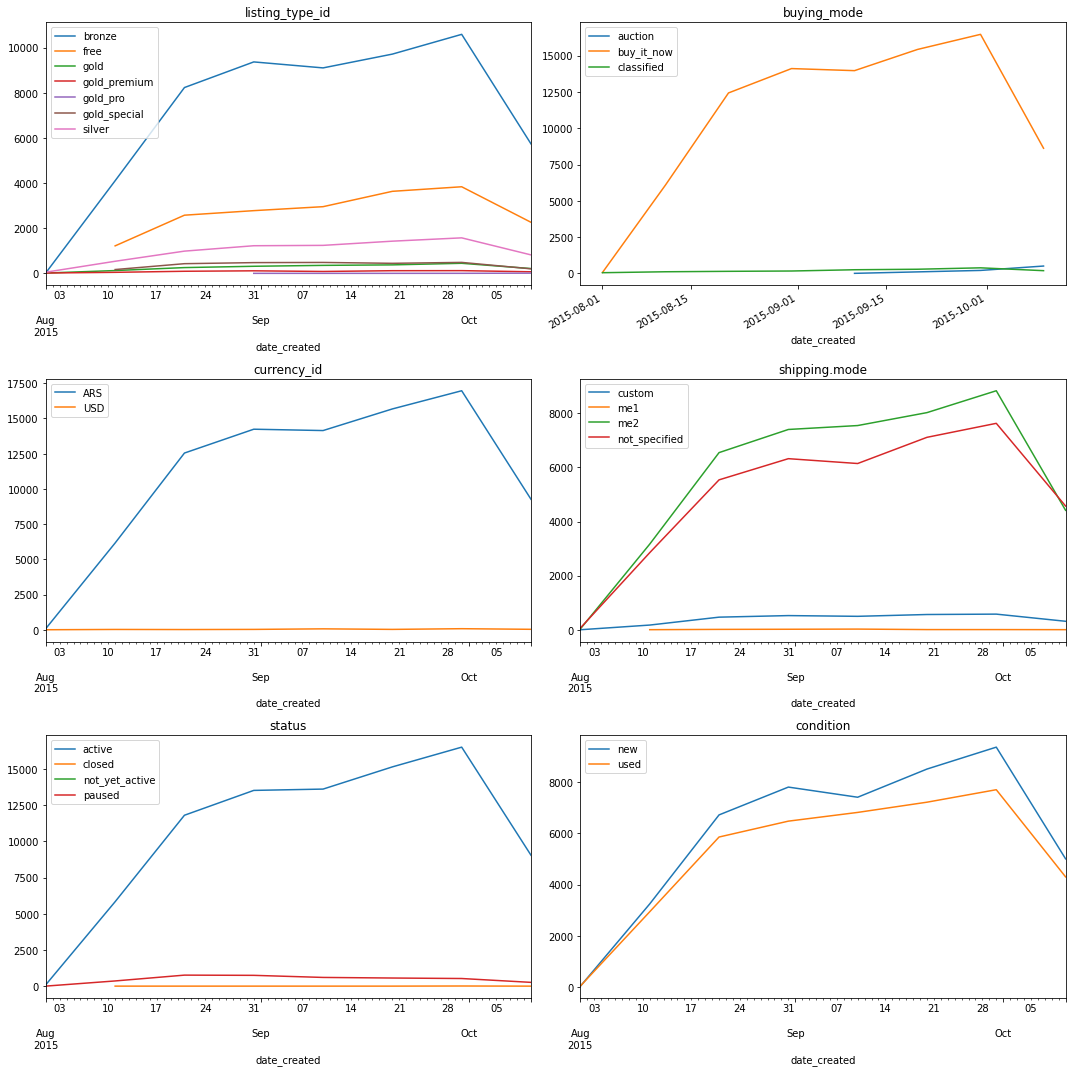

In [52]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(15, 15))
eda.plot_time_stability(X_train, 'date_created', 'listing_type_id', 'price', ax1)
eda.plot_time_stability(X_train, 'date_created', 'buying_mode', 'price', ax2)
eda.plot_time_stability(X_train, 'date_created', 'currency_id', 'price', ax3)
eda.plot_time_stability(X_train, 'date_created', 'shipping.mode', 'price', ax4)
eda.plot_time_stability(X_train, 'date_created', 'status', 'price', ax5)
eda.plot_time_stability(X_train, 'date_created', 'condition', 'price', ax6)
fig.tight_layout()
plt.show()

As a result, we are dropping some columns:
`buying_mode`, `currency_id`, `status`

In [53]:
X_train = X_train.drop(['buying_mode', 'currency_id', 'status'], axis=1)

### How are the categorical cols related to the class?

#### listing_type_id

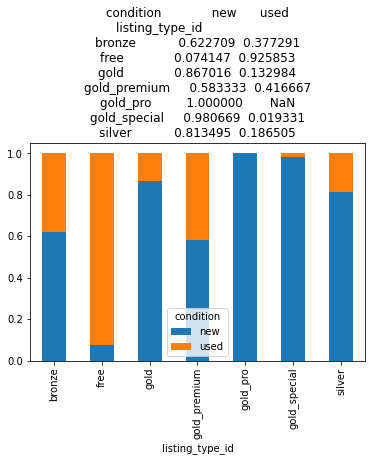

In [54]:
eda.bivariate_analysis_categorical(X_train, 'condition', 'listing_type_id')

#### shipping.mode

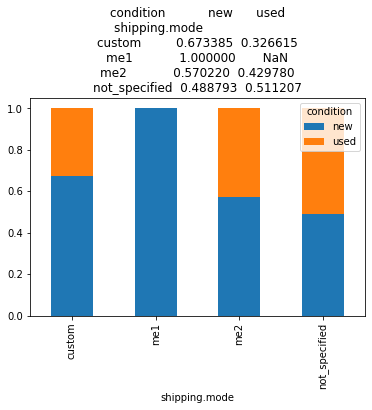

In [55]:
eda.bivariate_analysis_categorical(X_train, 'condition', 'shipping.mode')

### Do the numerical features have high correlation between themselves?

- Boolean columns need to be numerical

In [56]:
X_train[['accepts_mercadopago',
         'automatic_relist',
         'shipping.local_pick_up',
         'shipping.free_shipping']] = X_train[['accepts_mercadopago',
                                               'automatic_relist',
                                               'shipping.local_pick_up',
                                               'shipping.free_shipping']].astype(int)

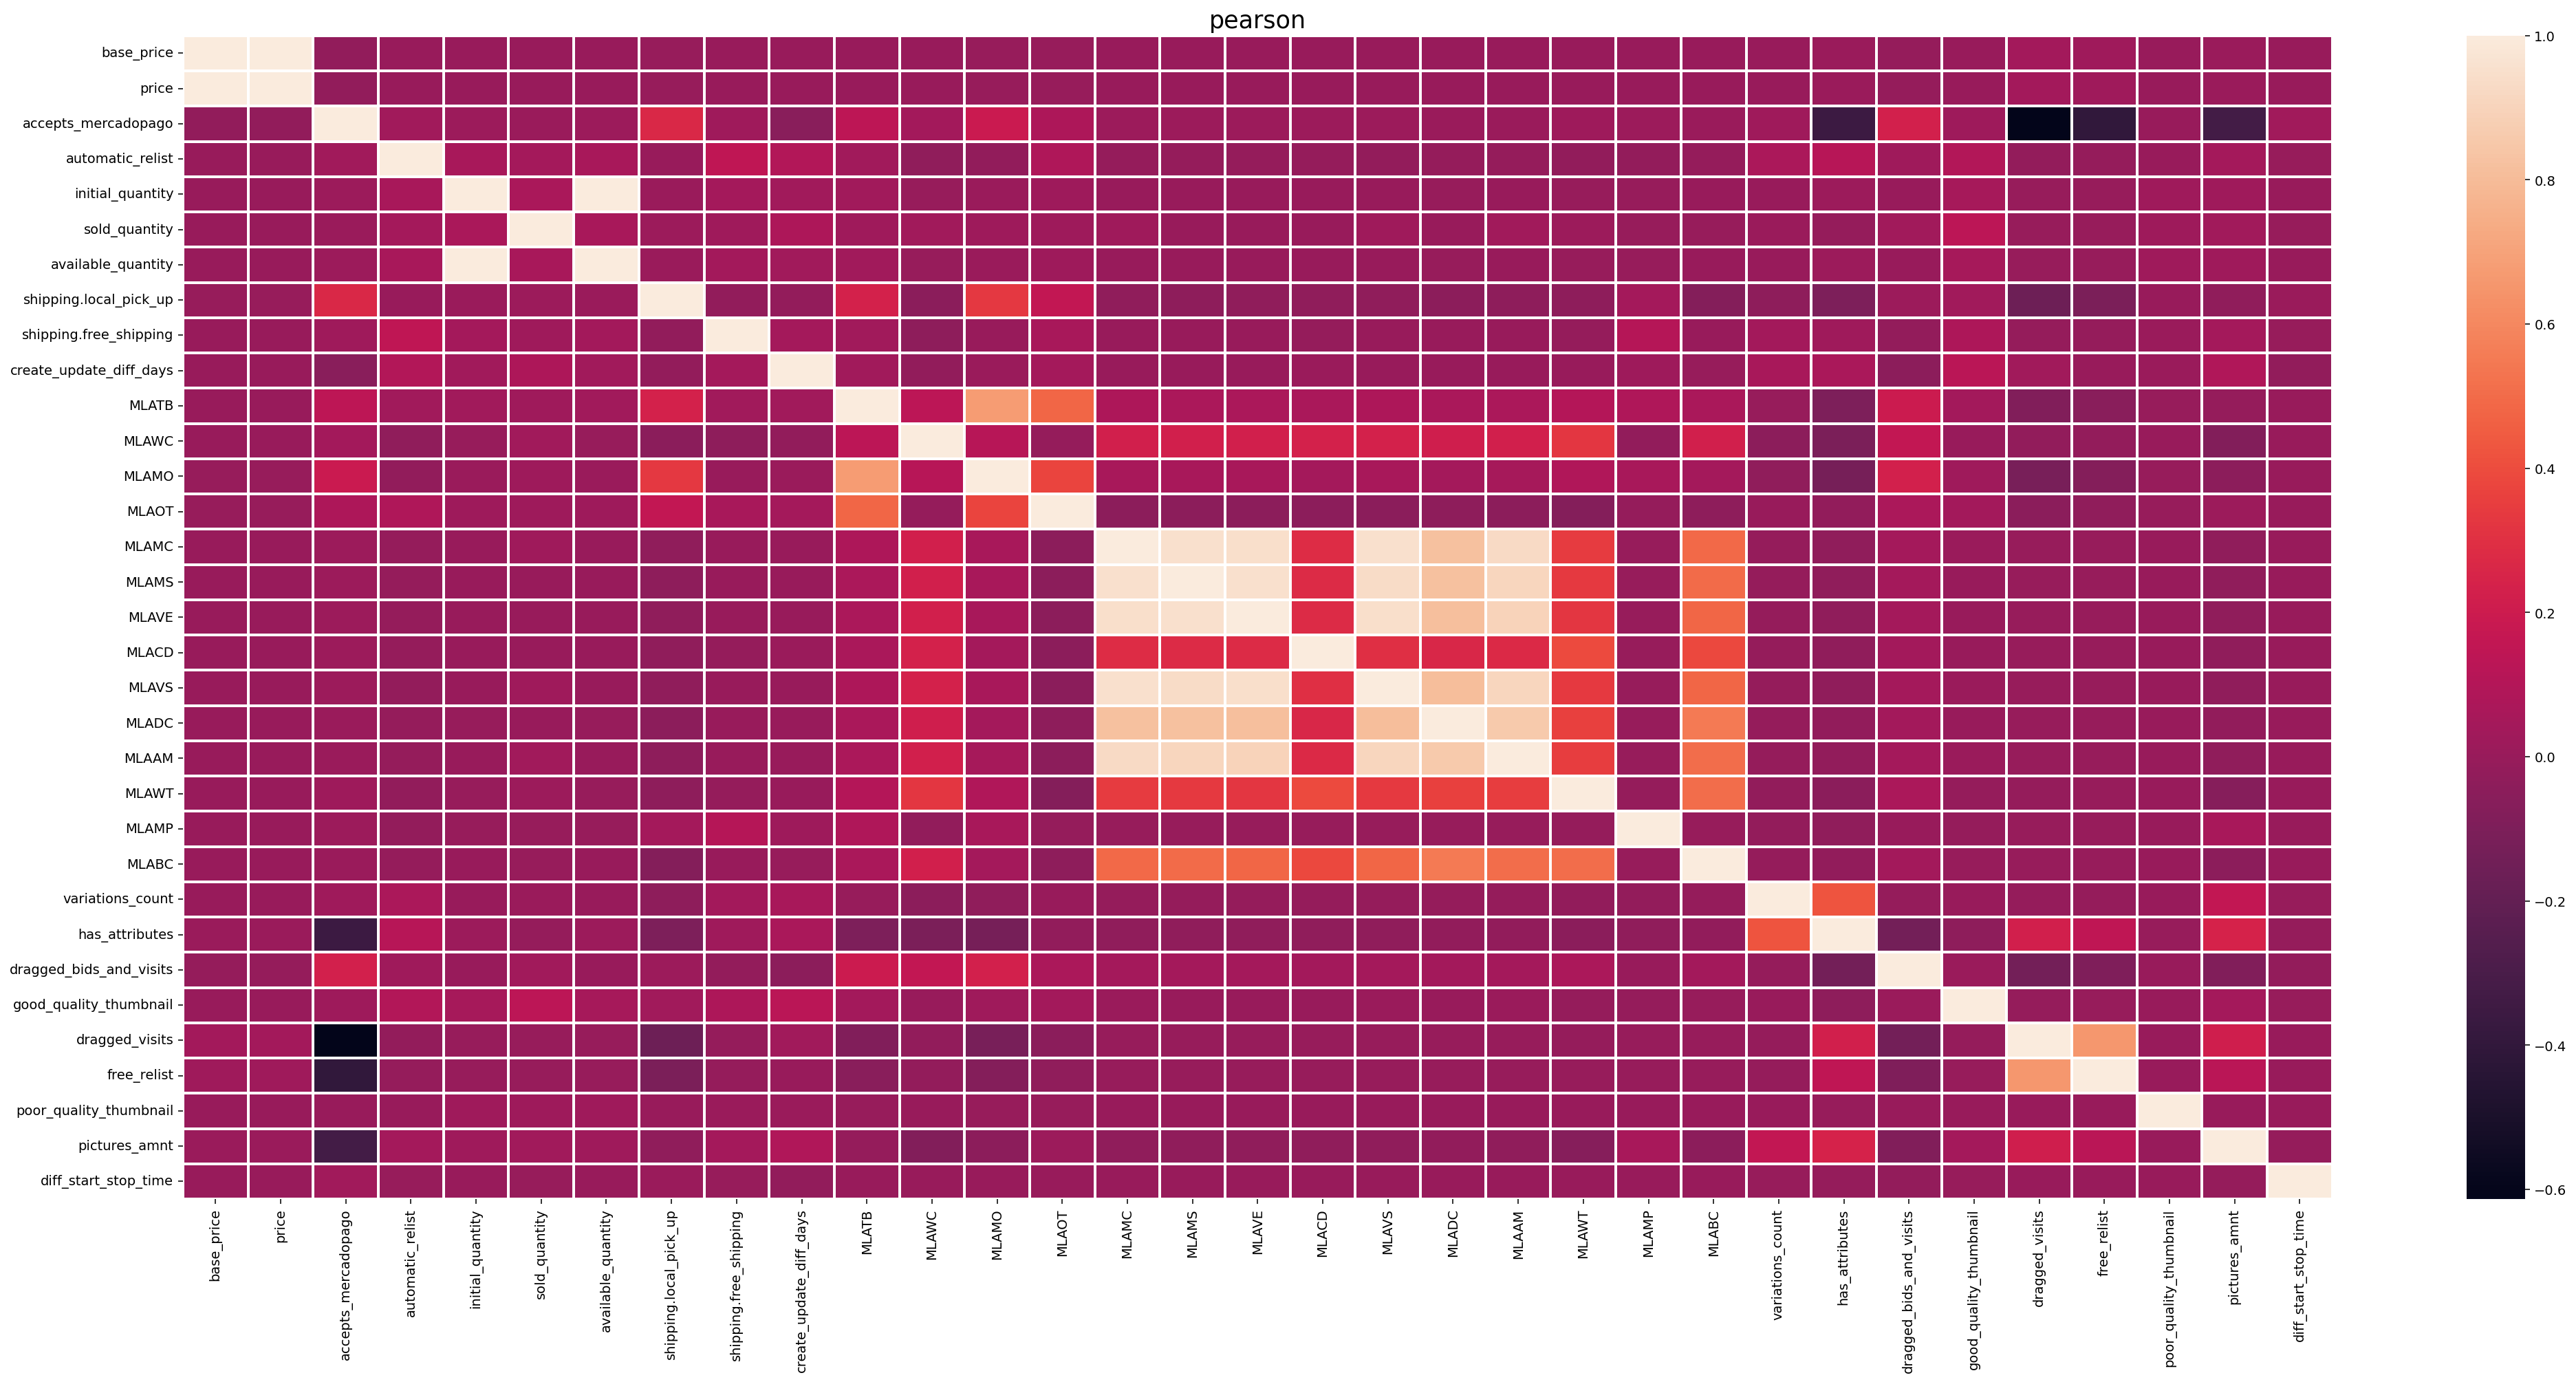

In [57]:
eda.correlation_heatmap(X_train, ['pearson'])

- Let's drop highly correlated columns

In [58]:
corr_matrix = X_train.corr().abs()

upper = corr_matrix.where(
    np.triu(
        np.ones(corr_matrix.shape), k=1
    ).astype(bool))

to_drop = [column for column in upper.columns 
           if any(upper[column] > 0.92)]

X_train = X_train.drop(to_drop, axis=1)

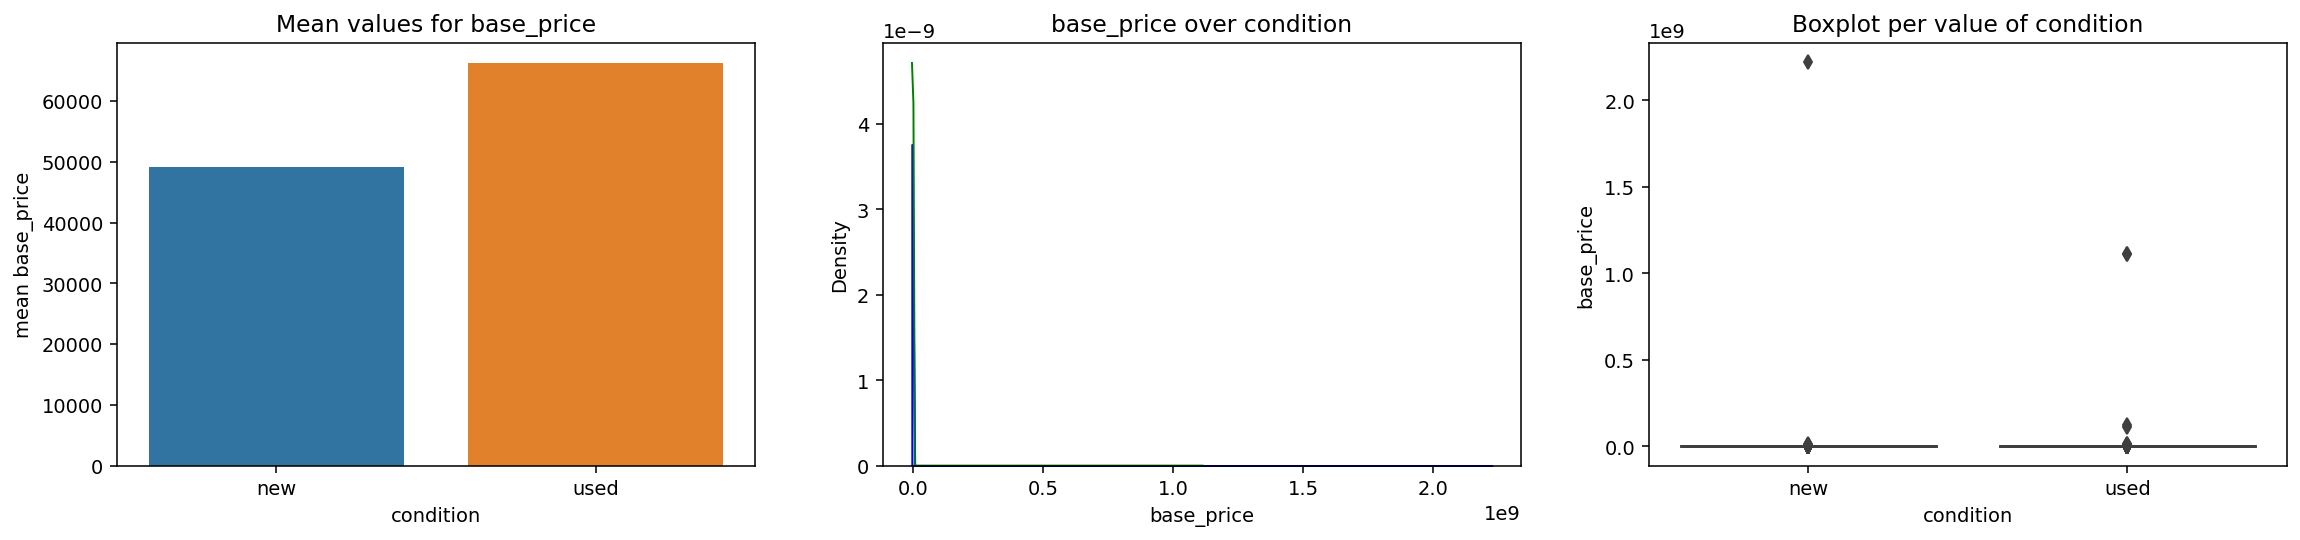

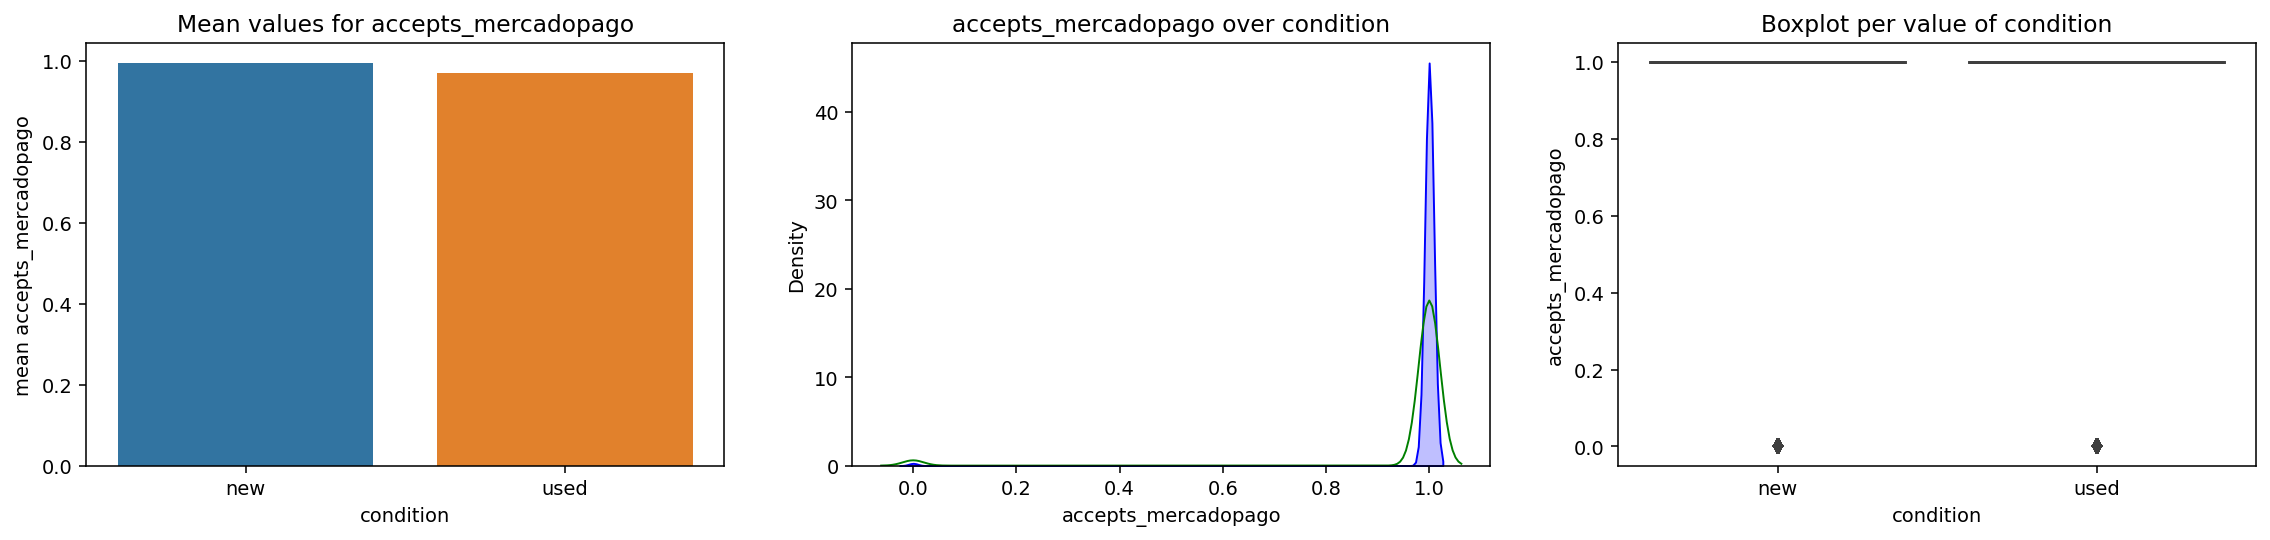

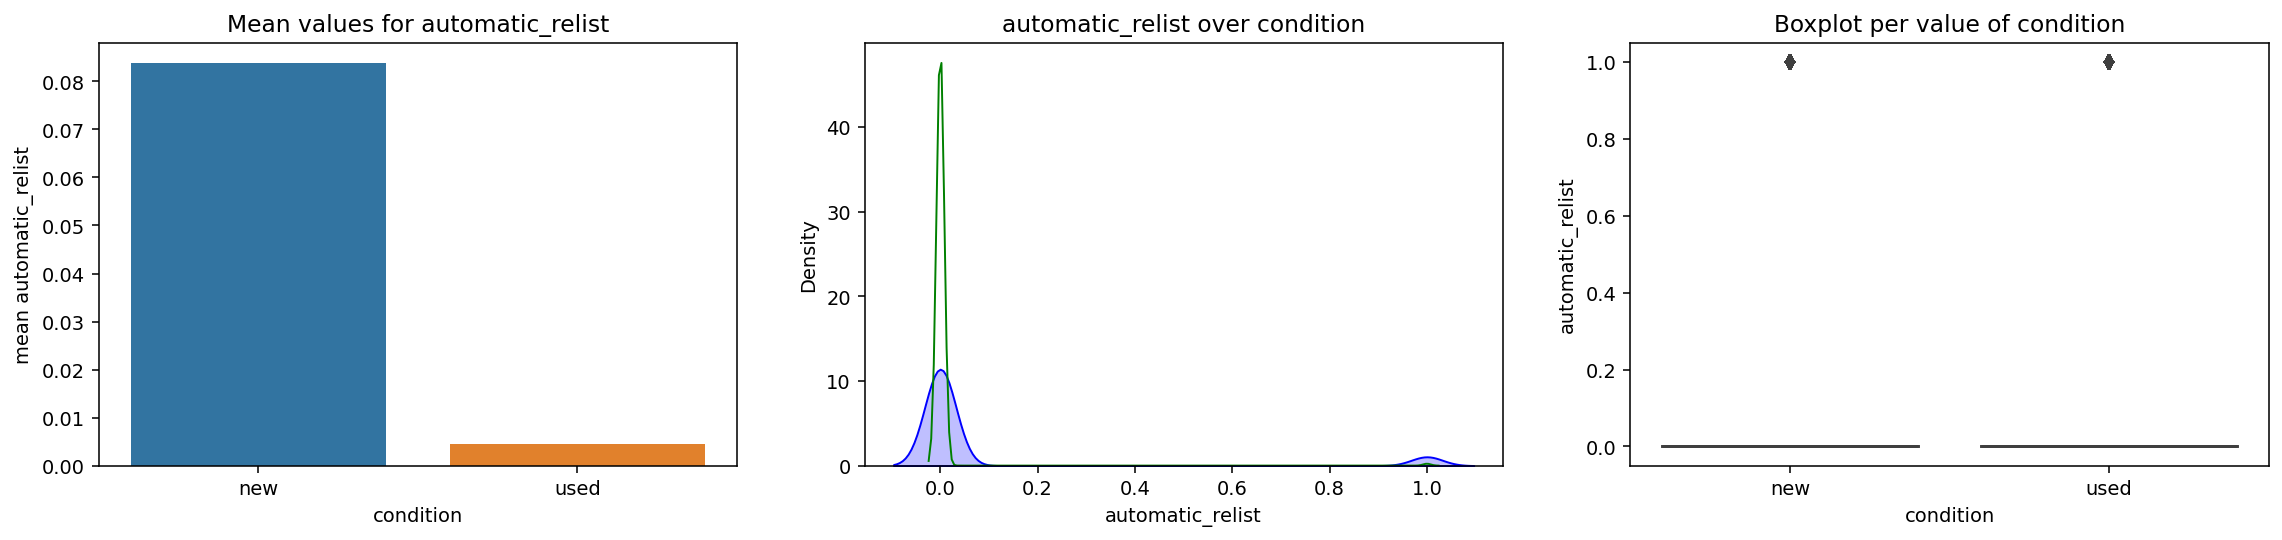

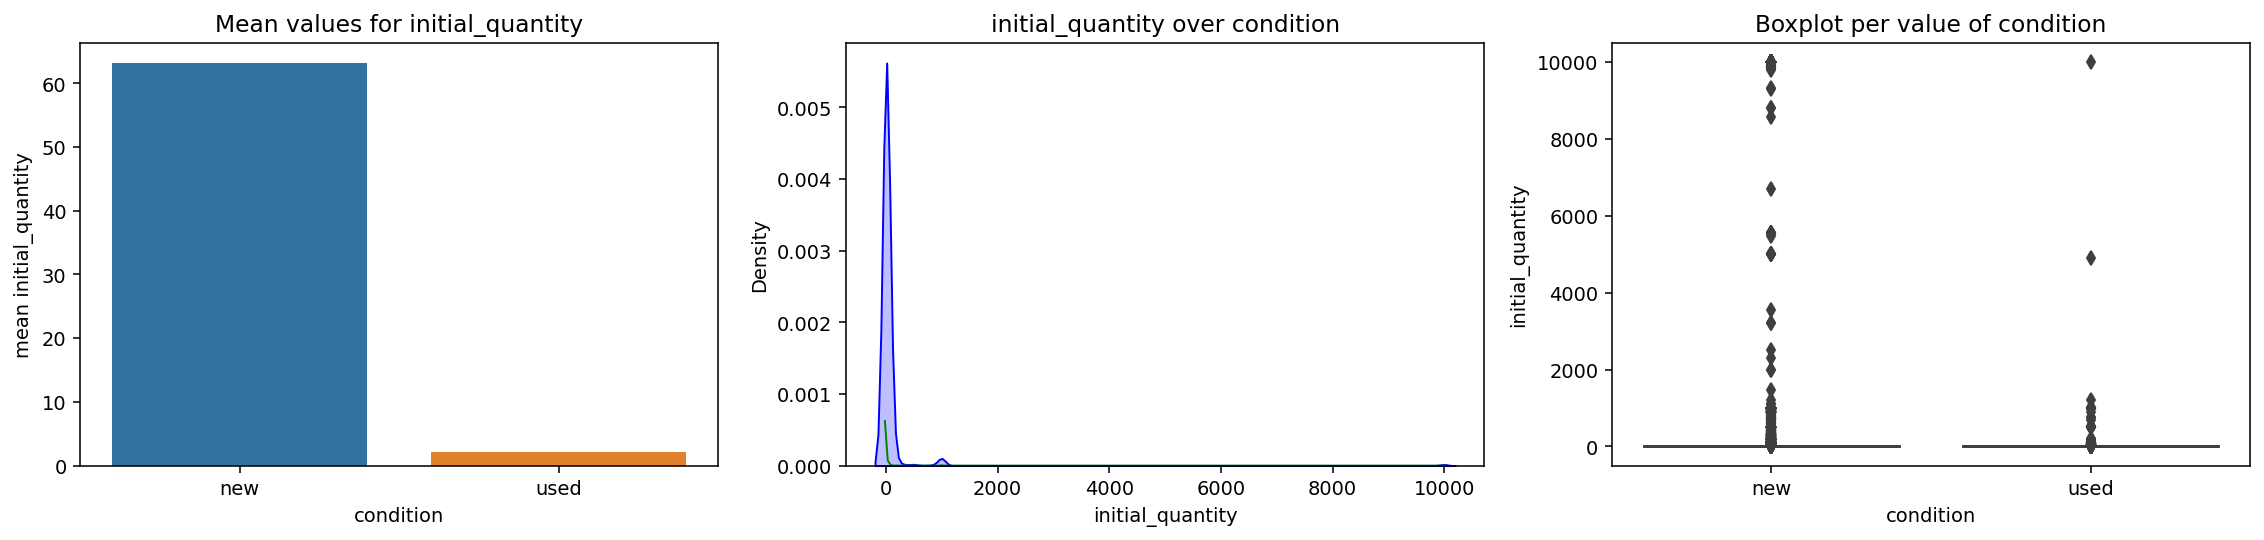

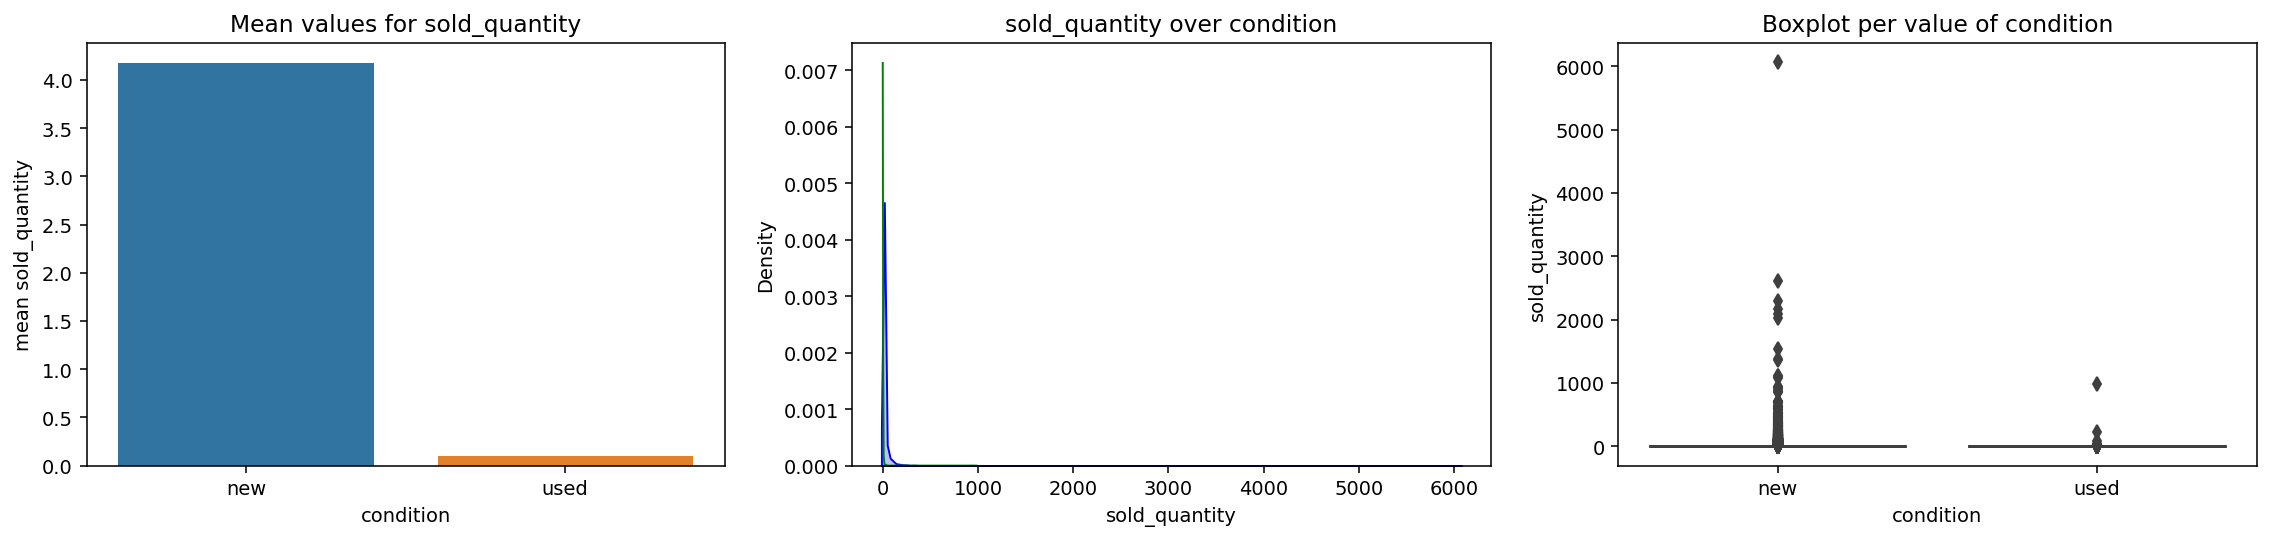

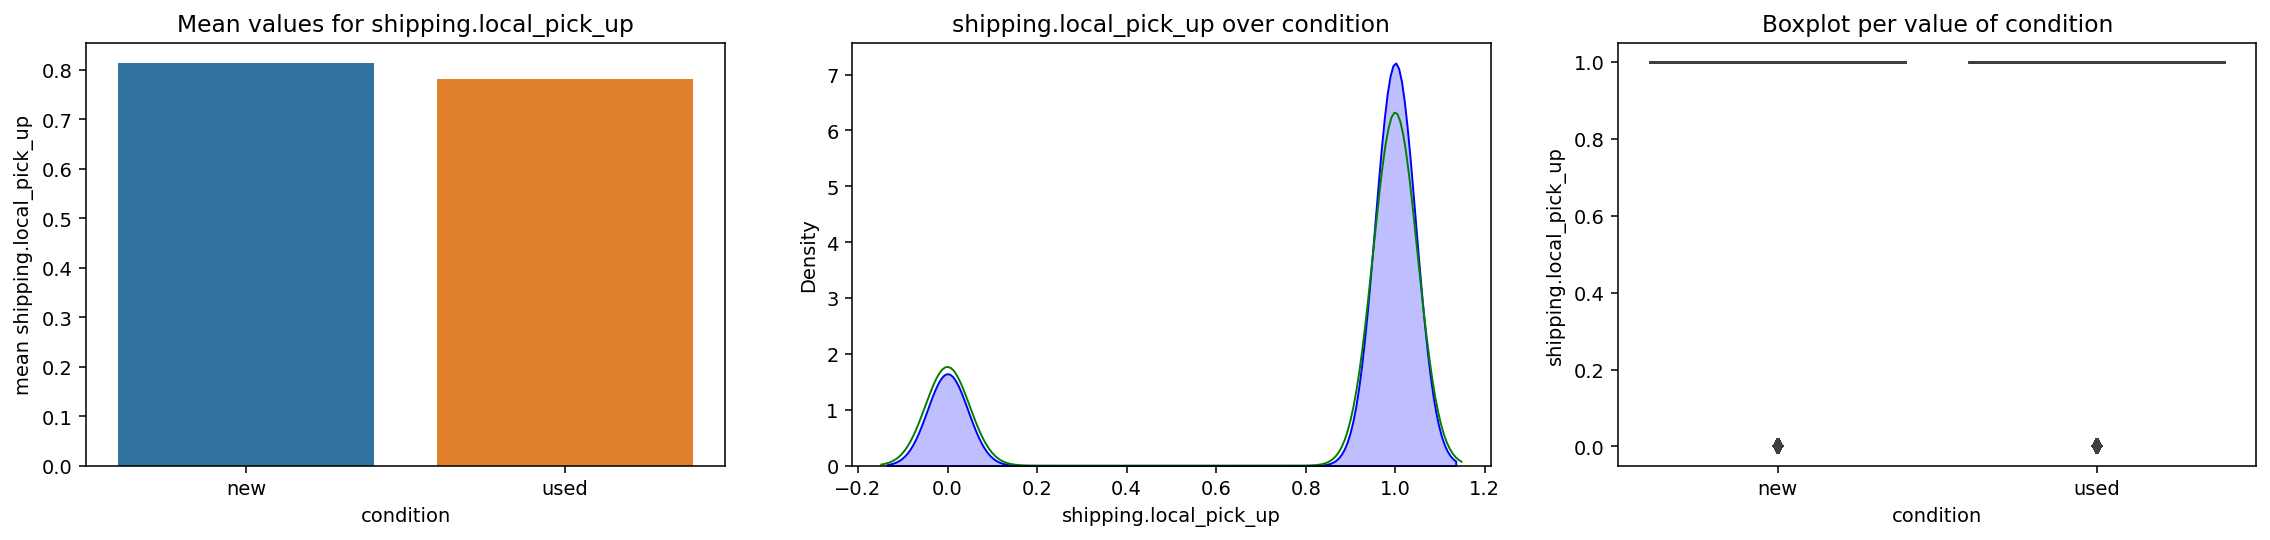

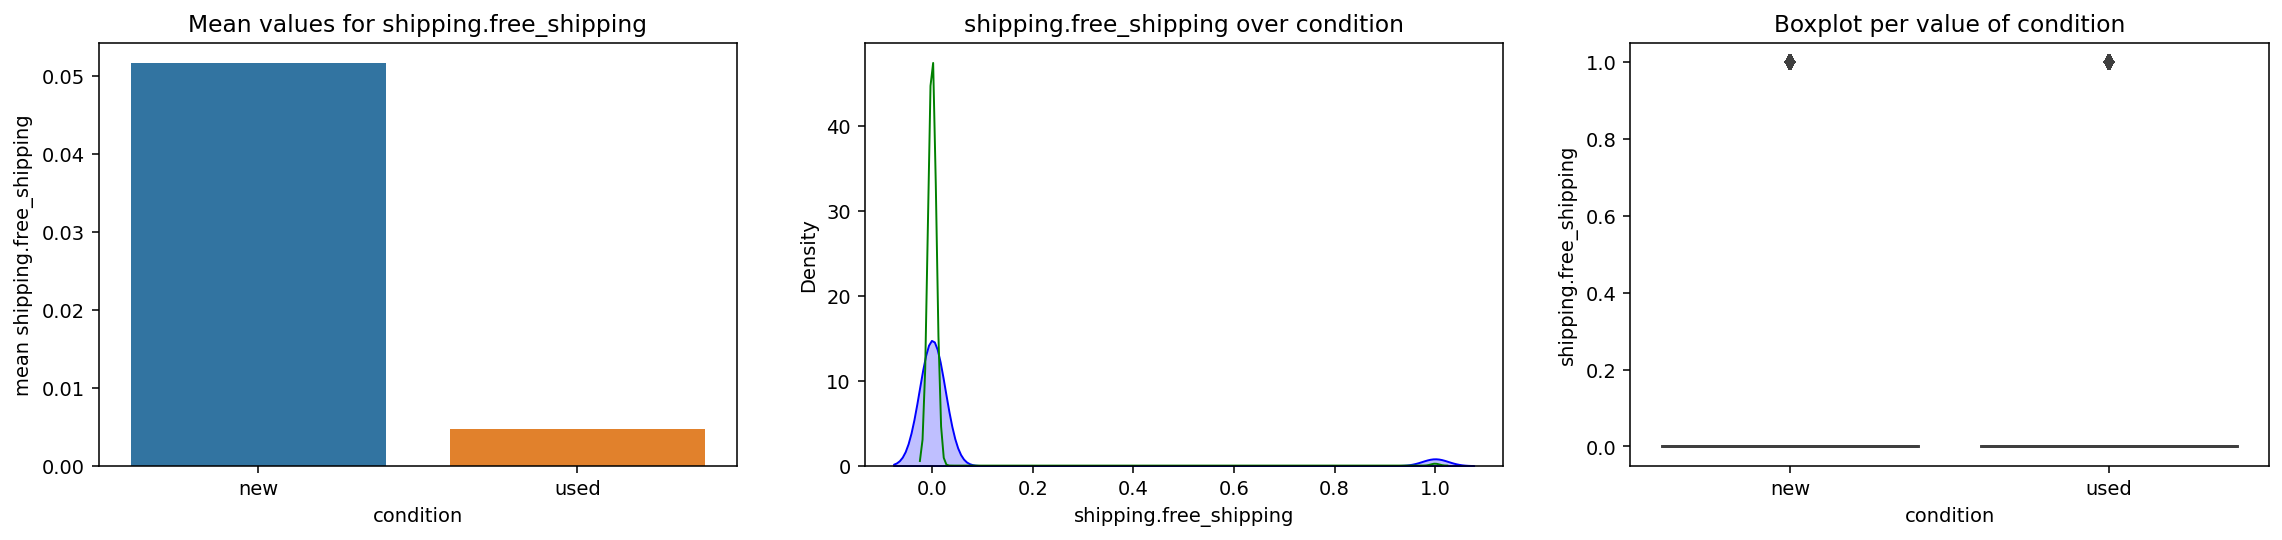

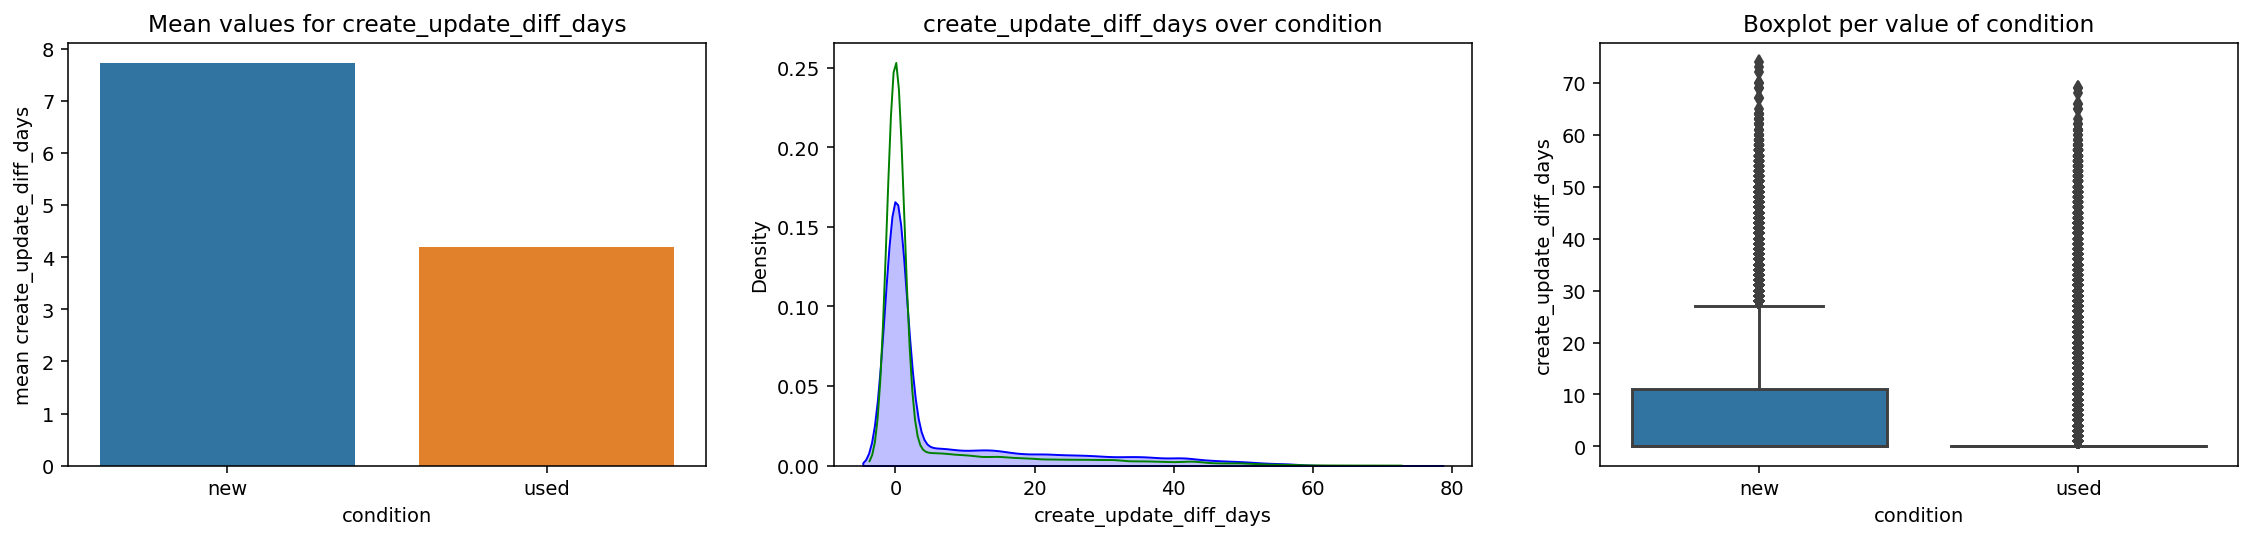

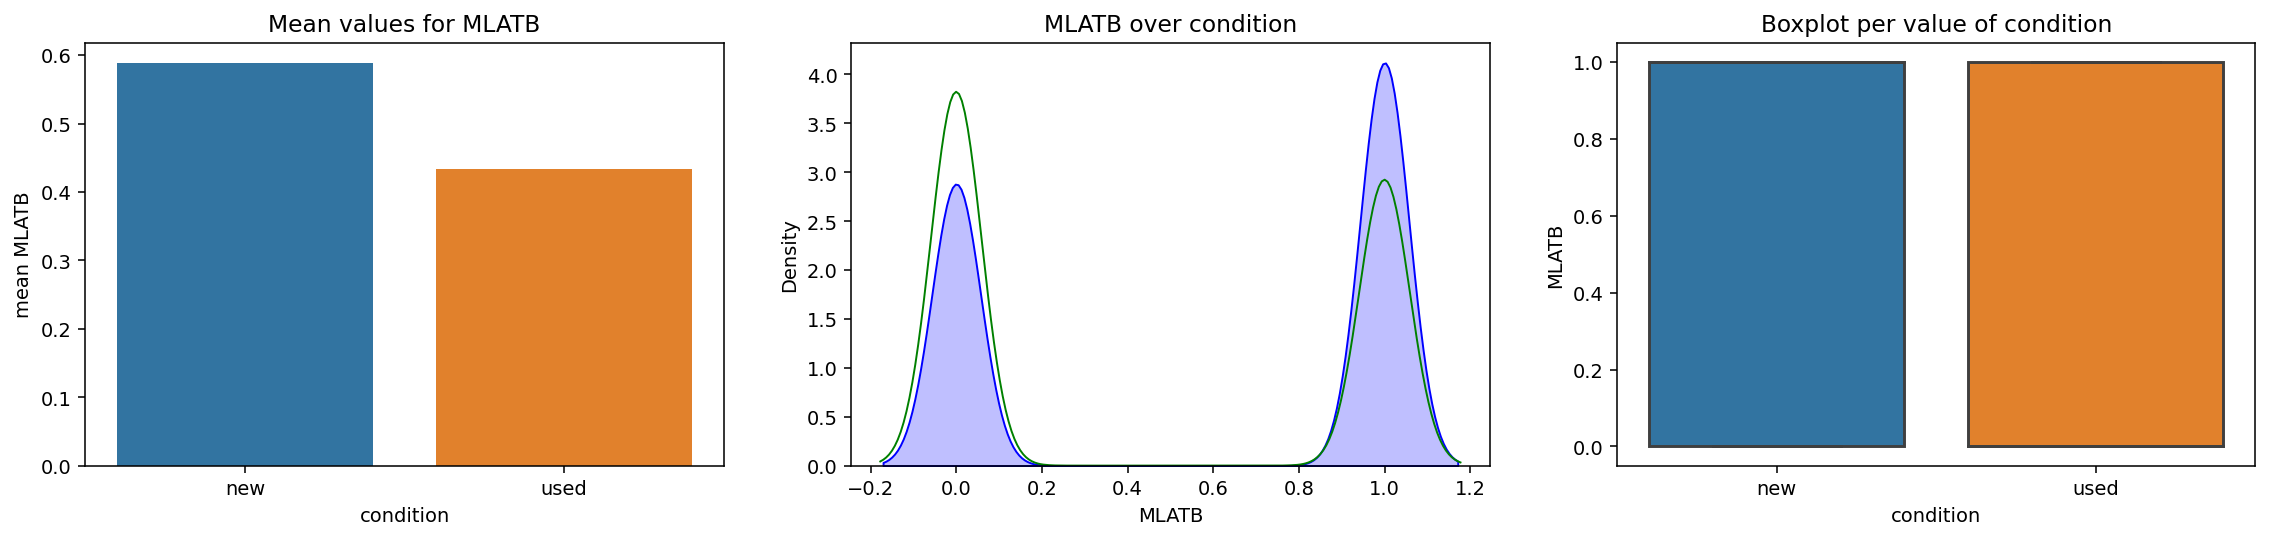

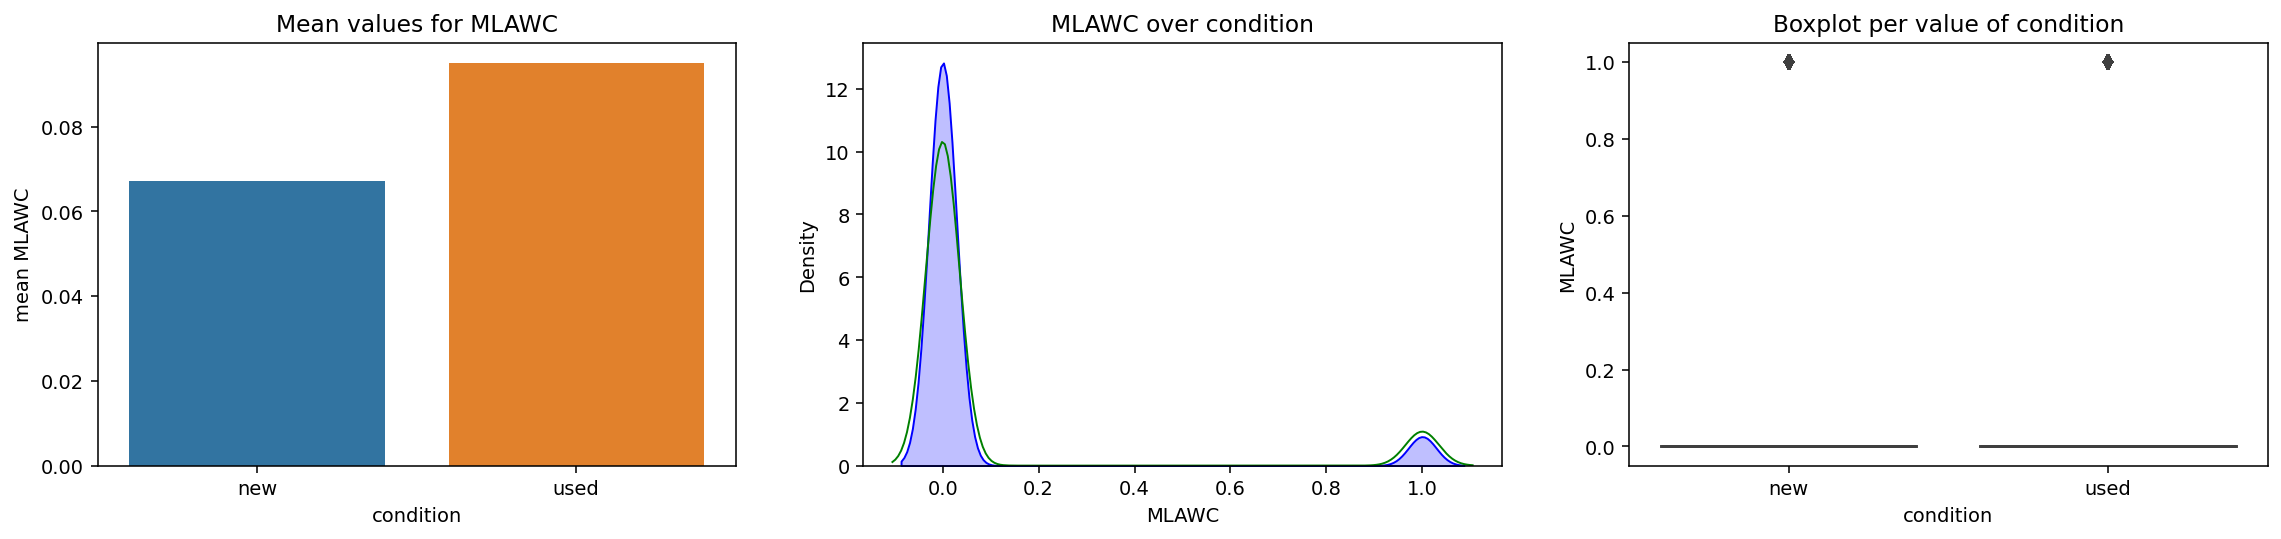

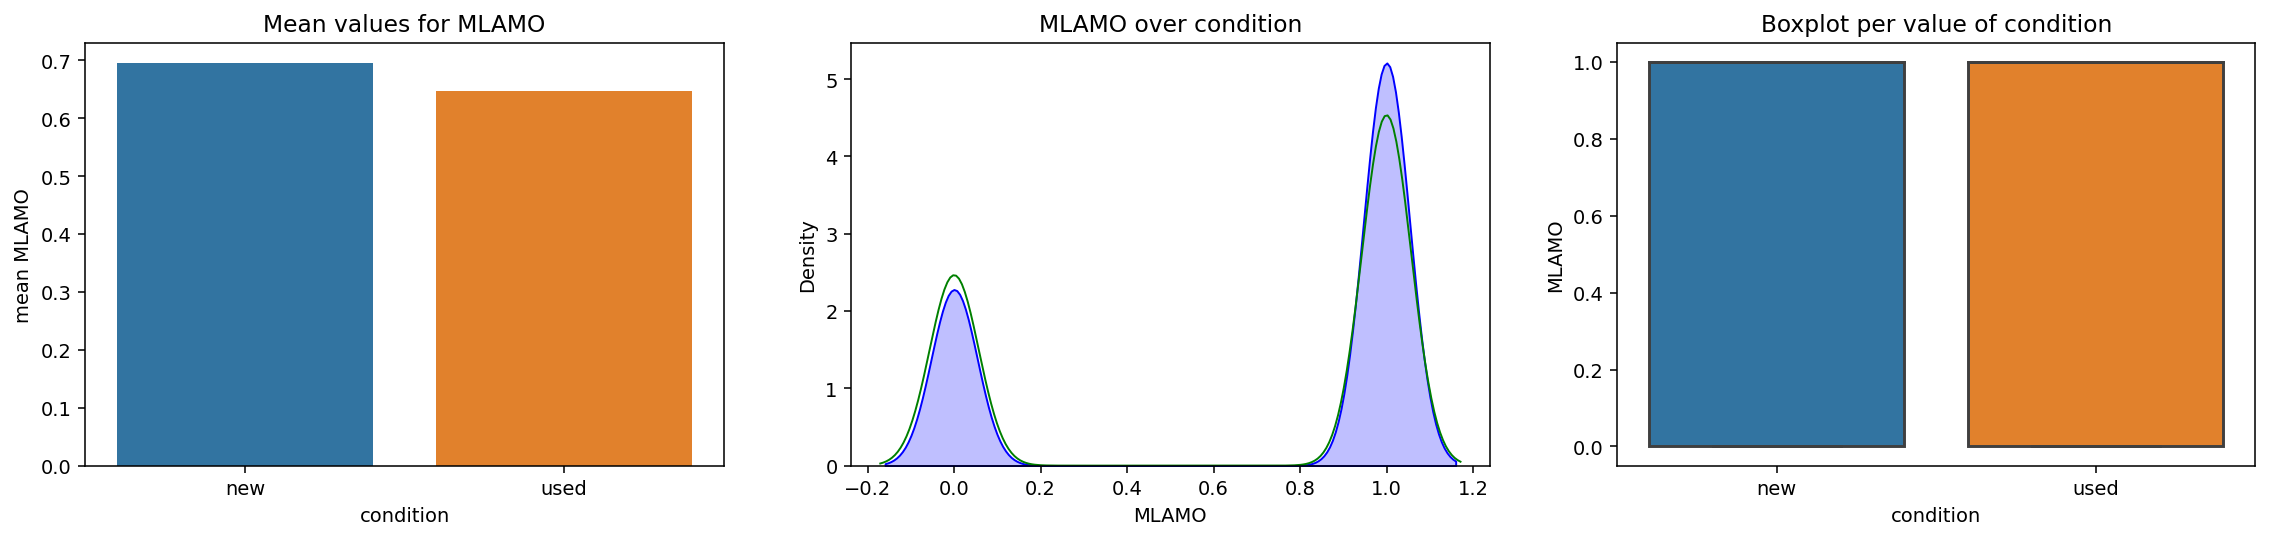

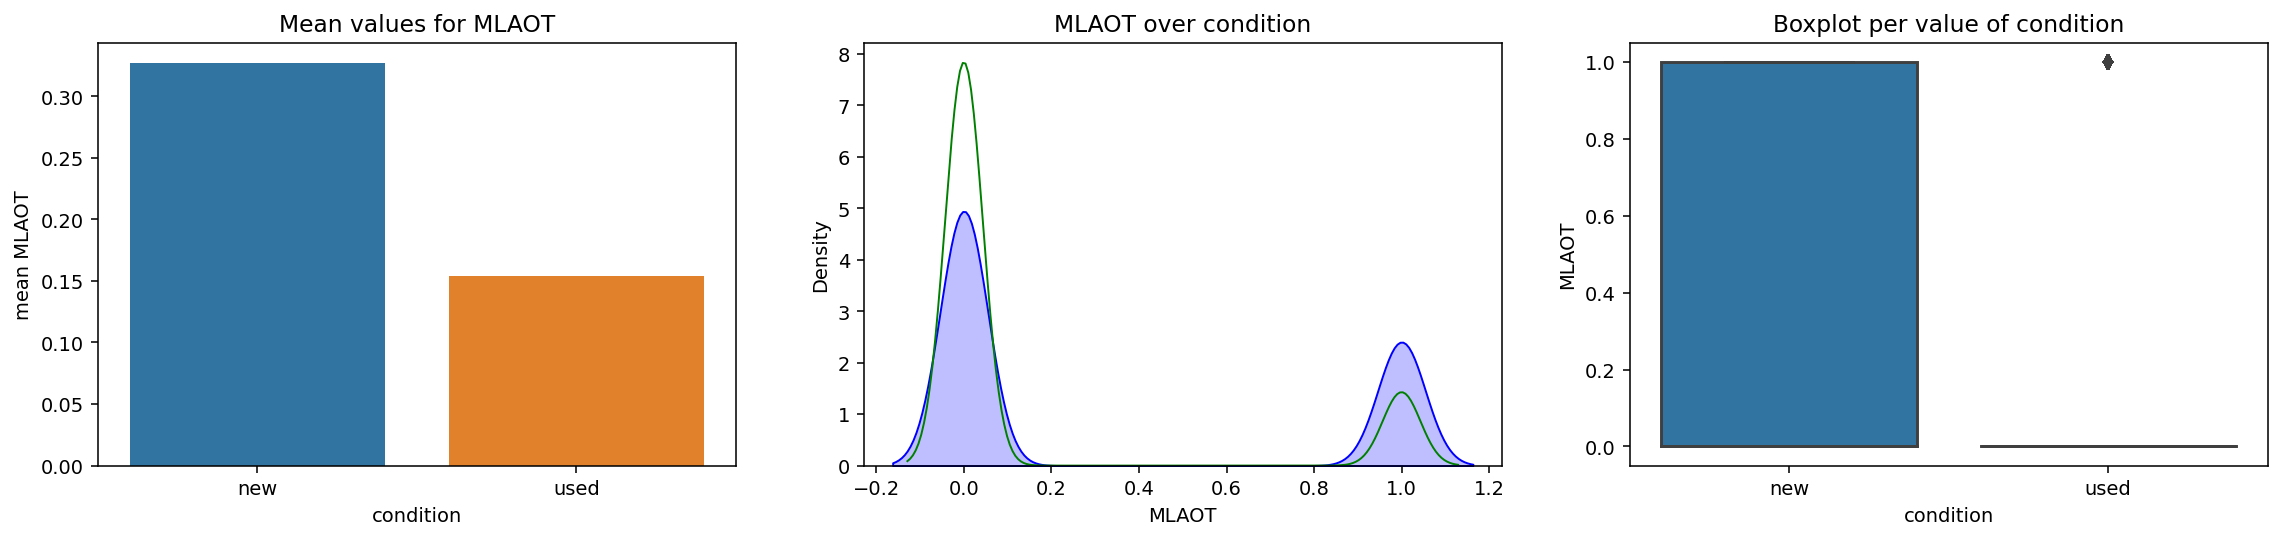

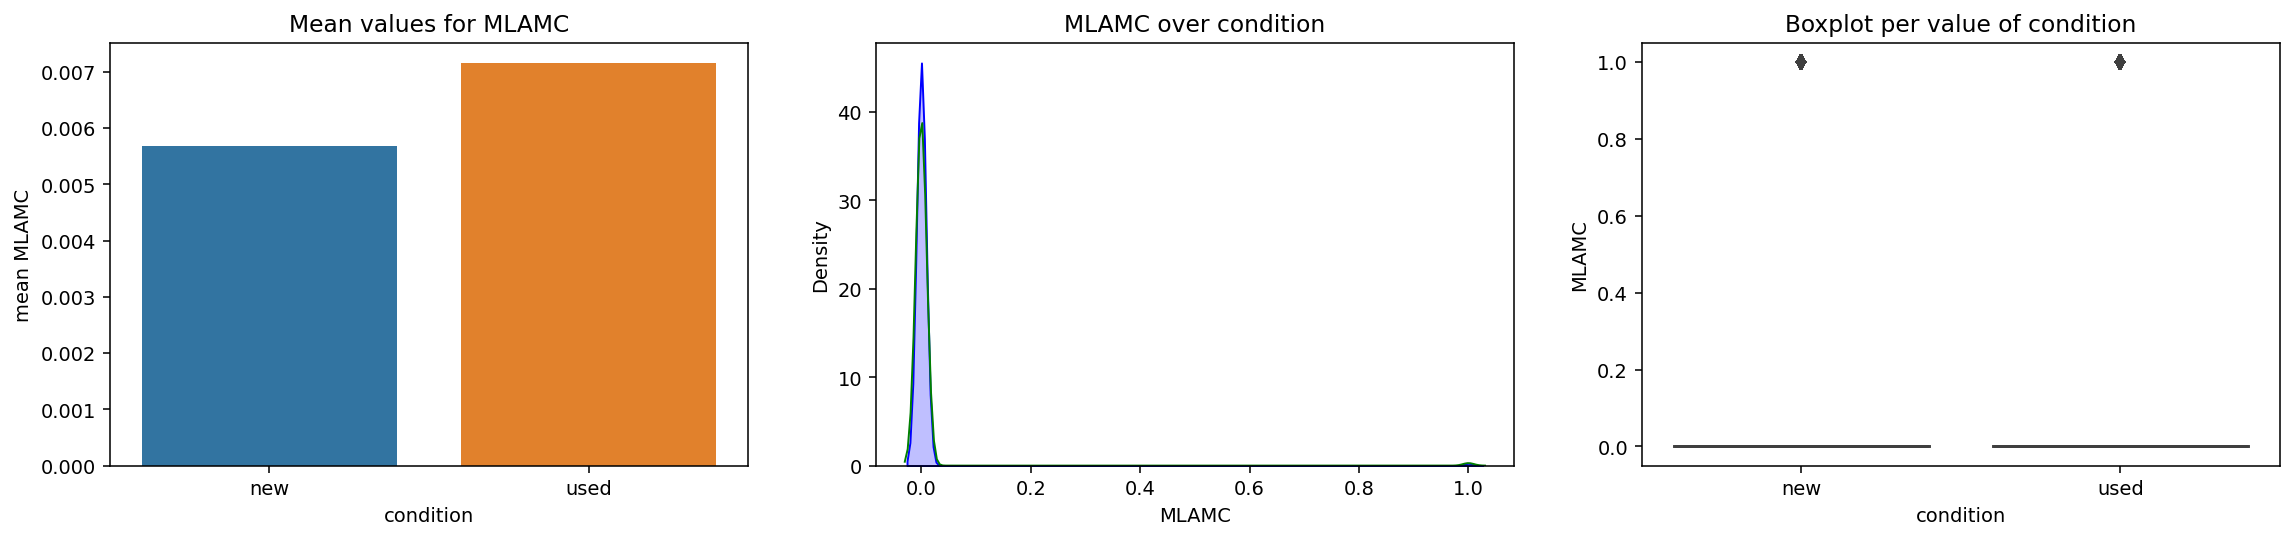

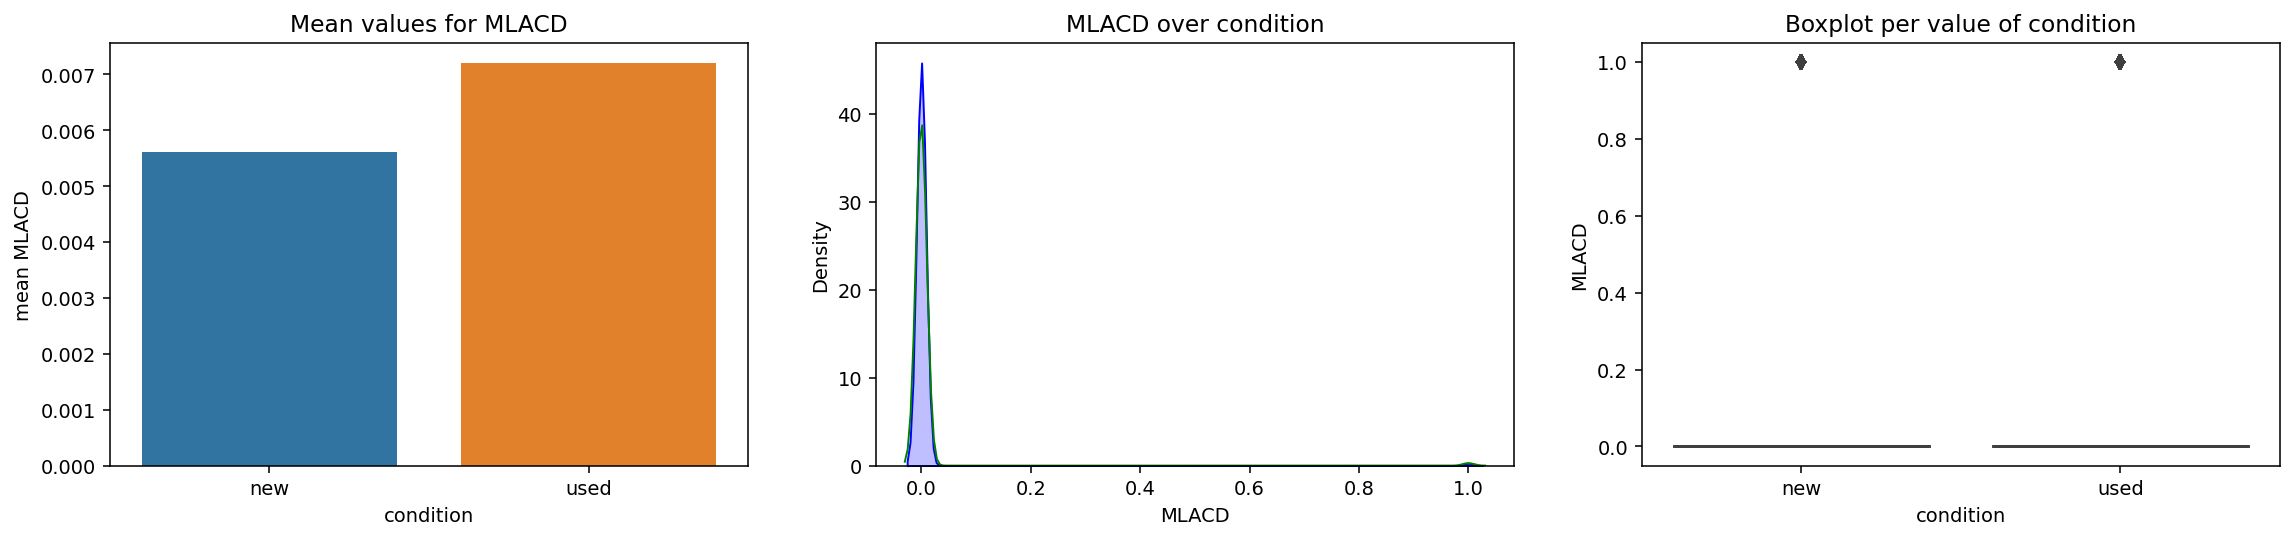

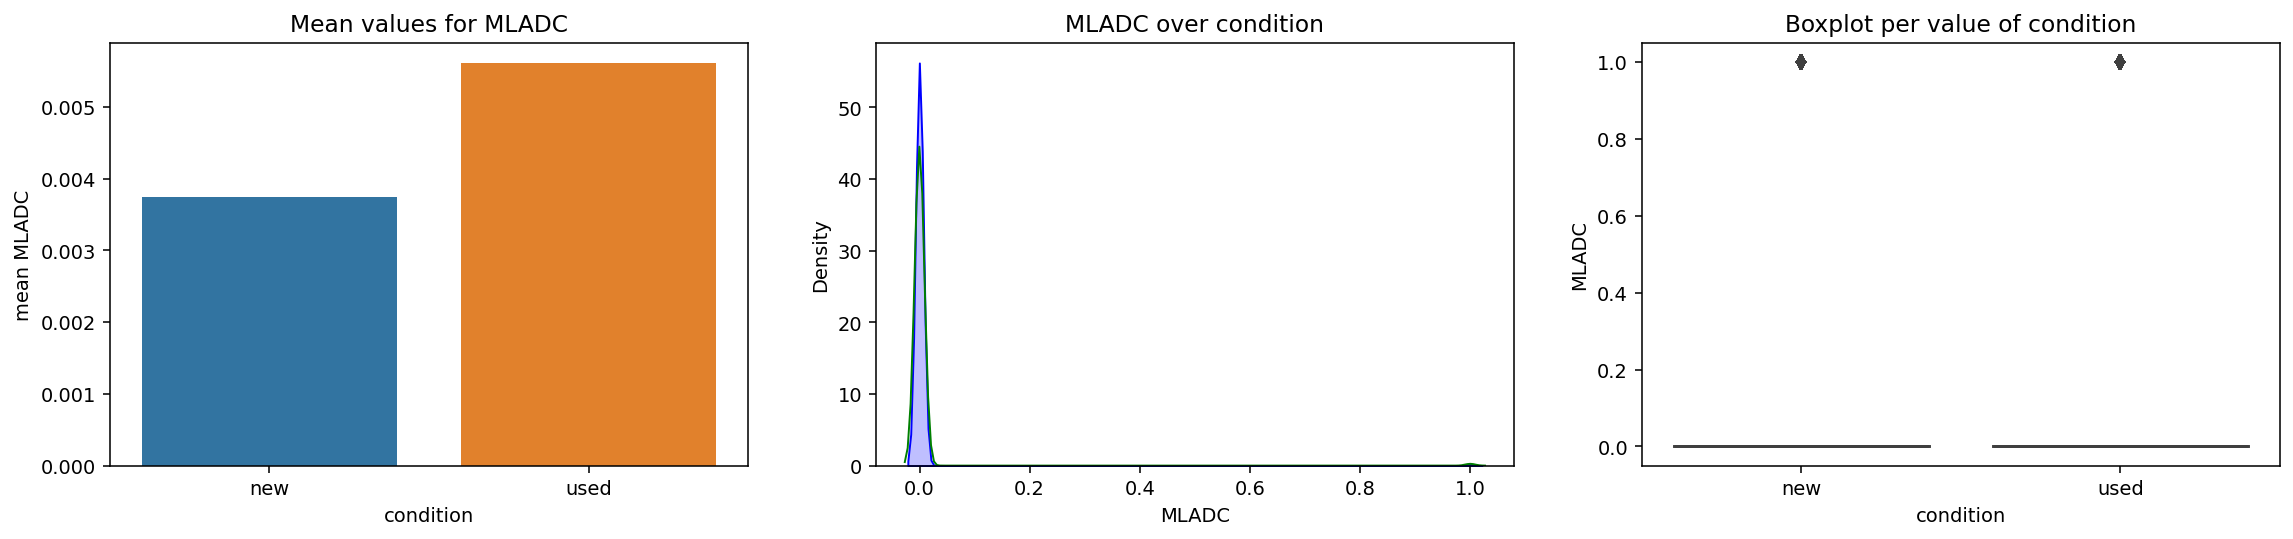

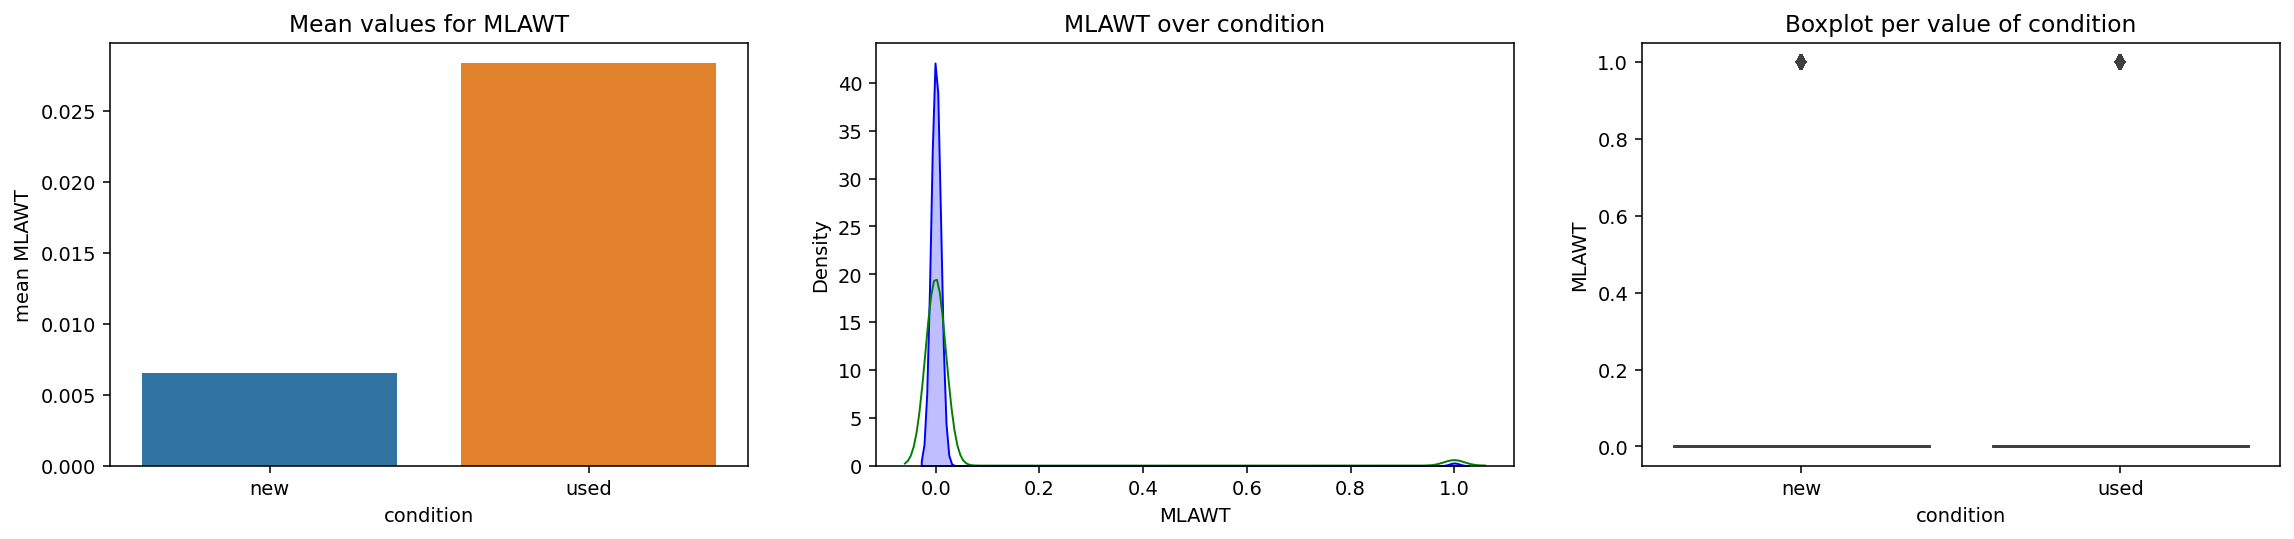

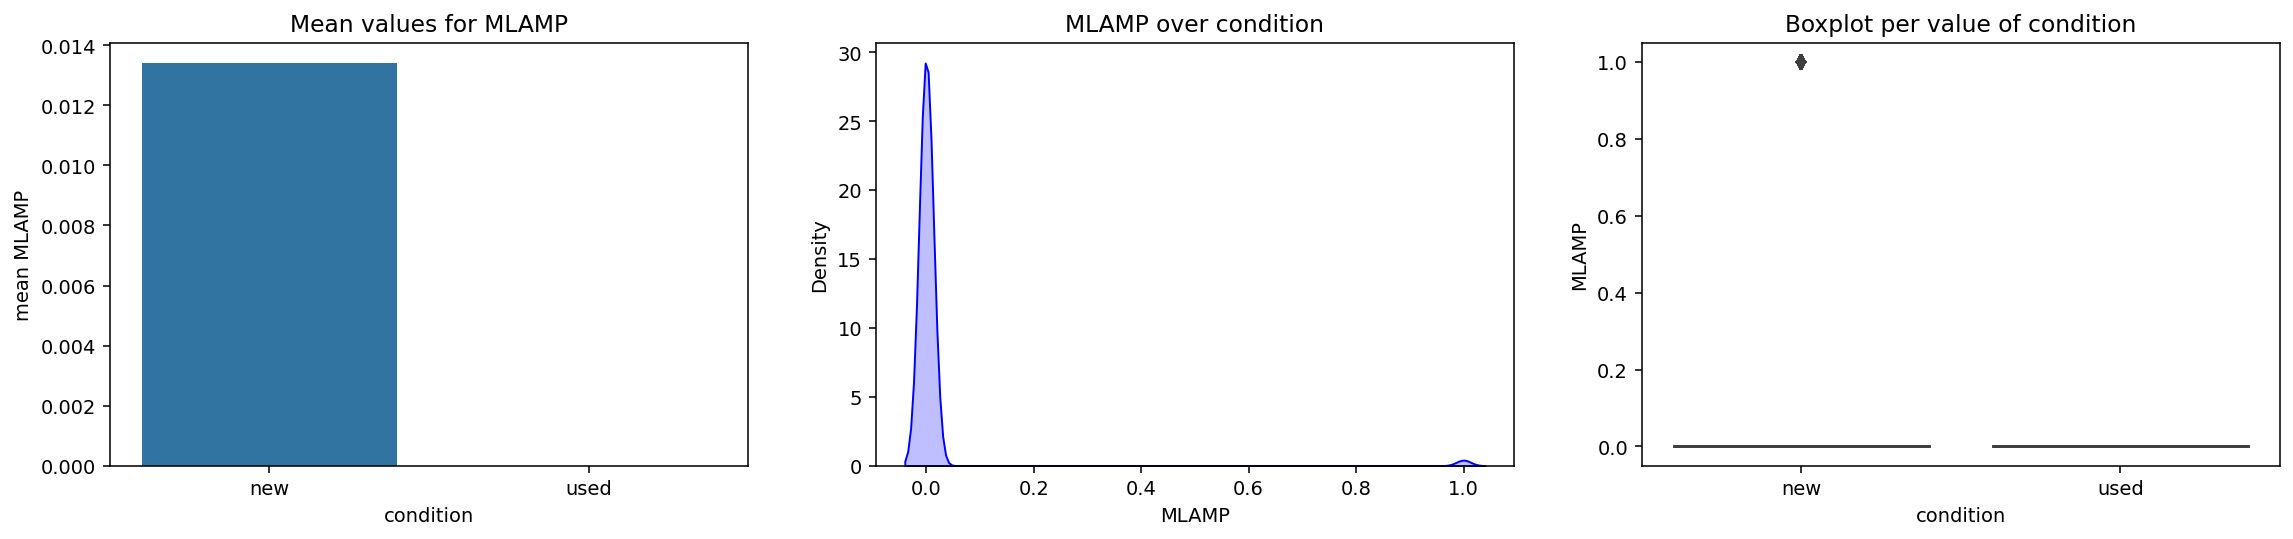

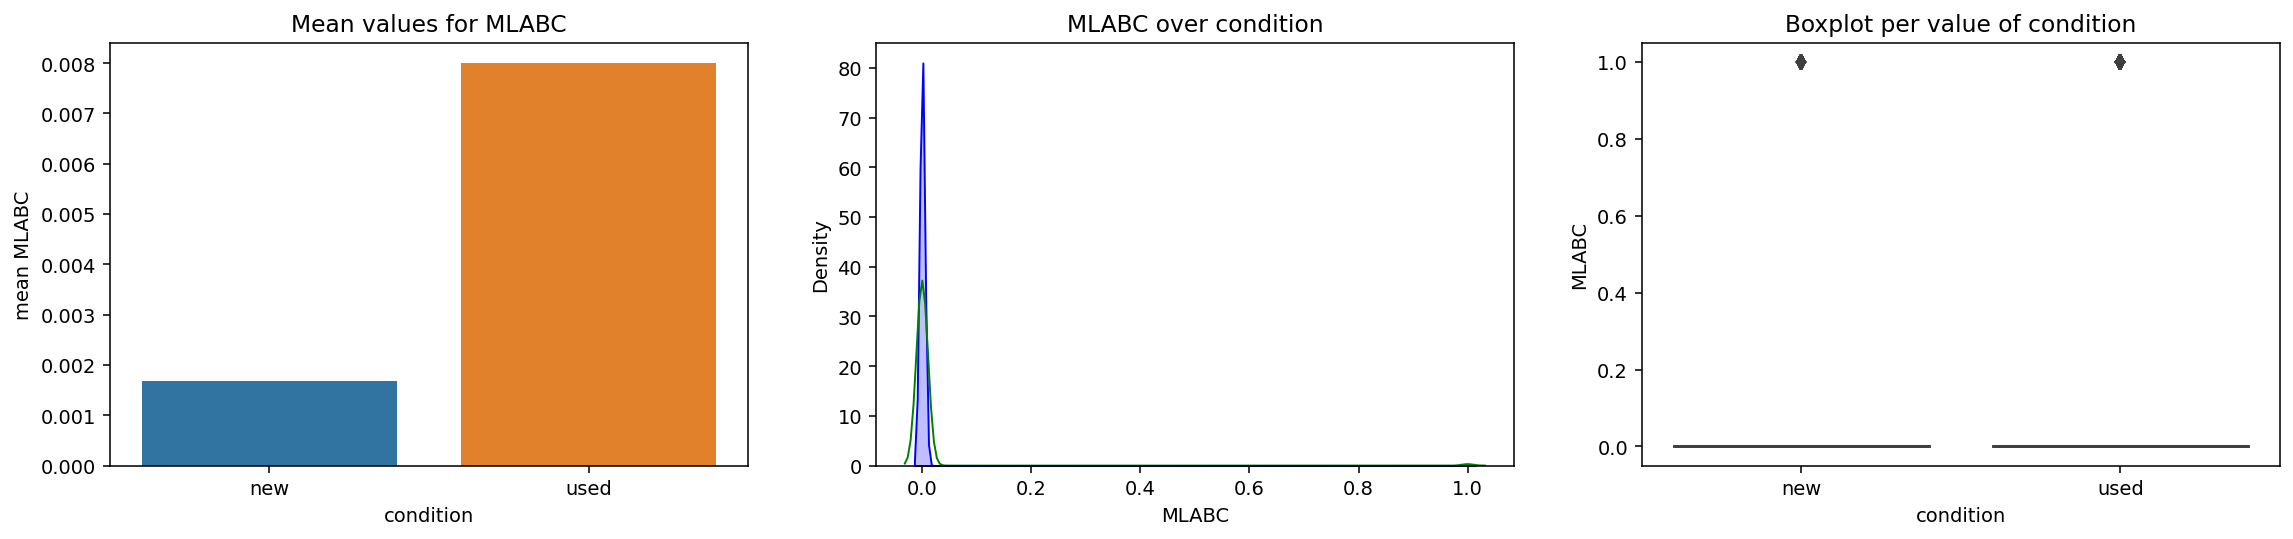

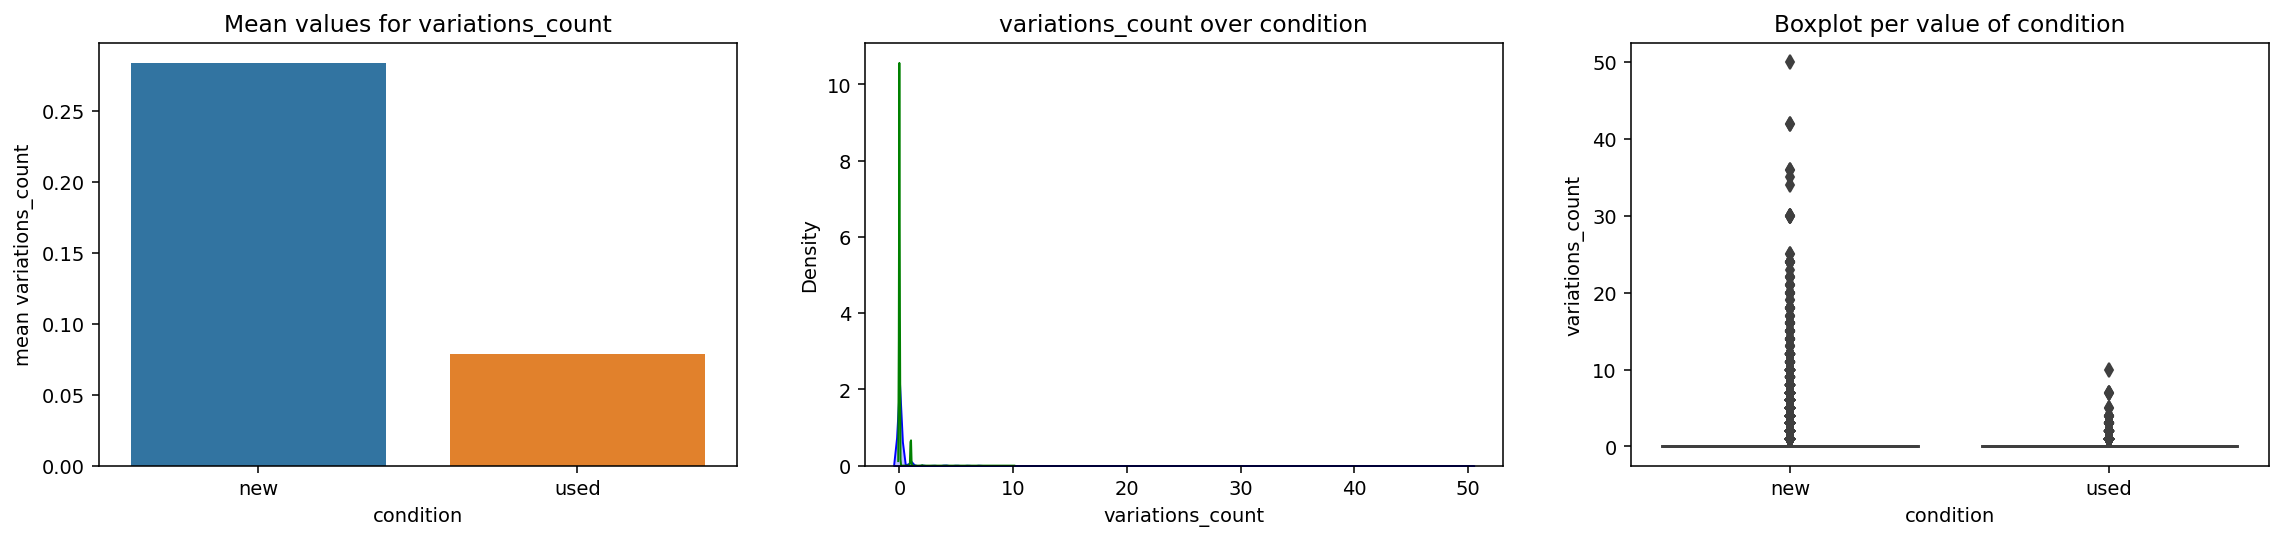

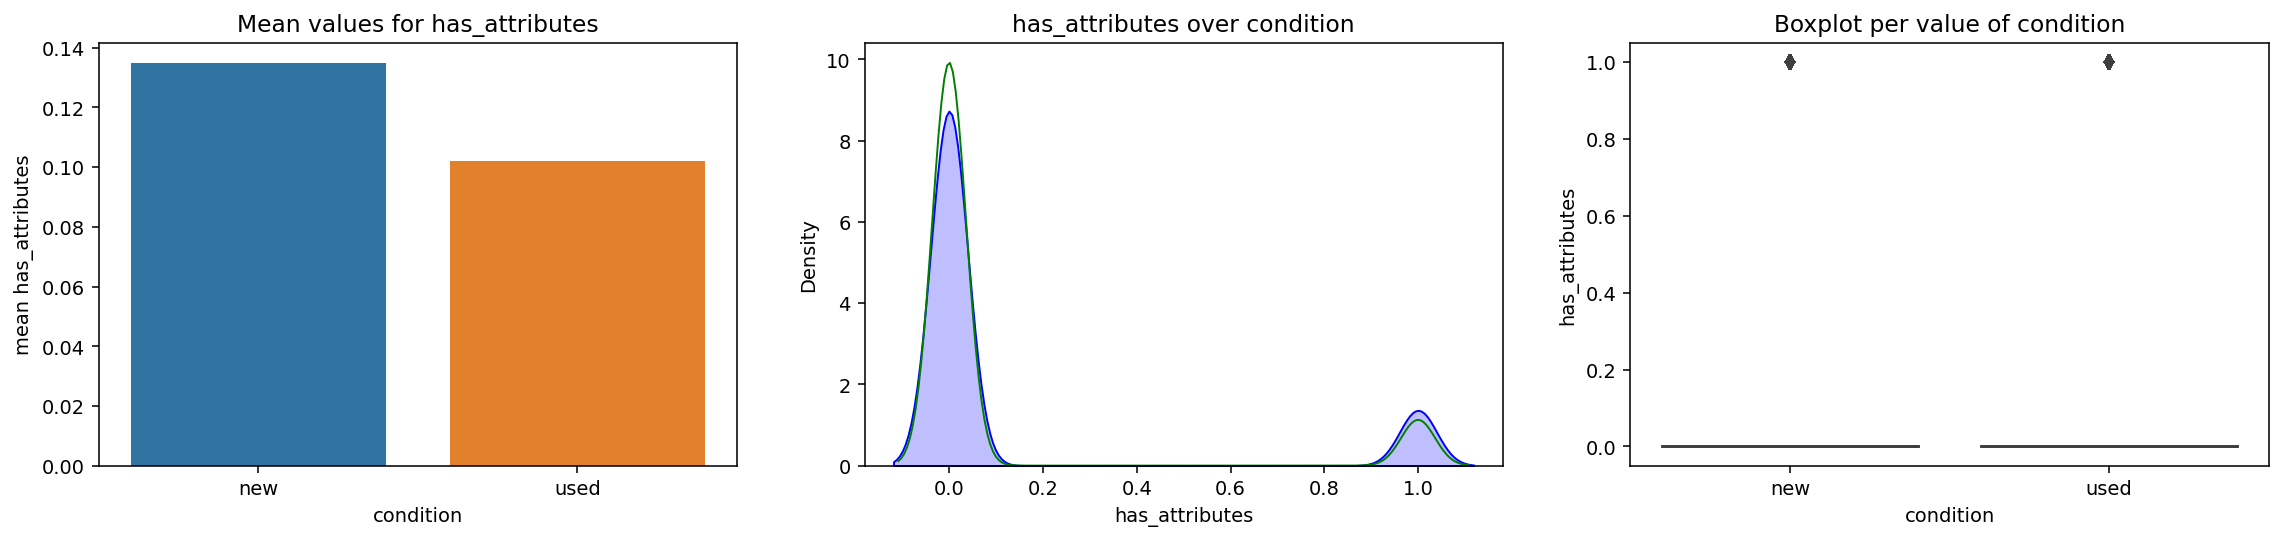

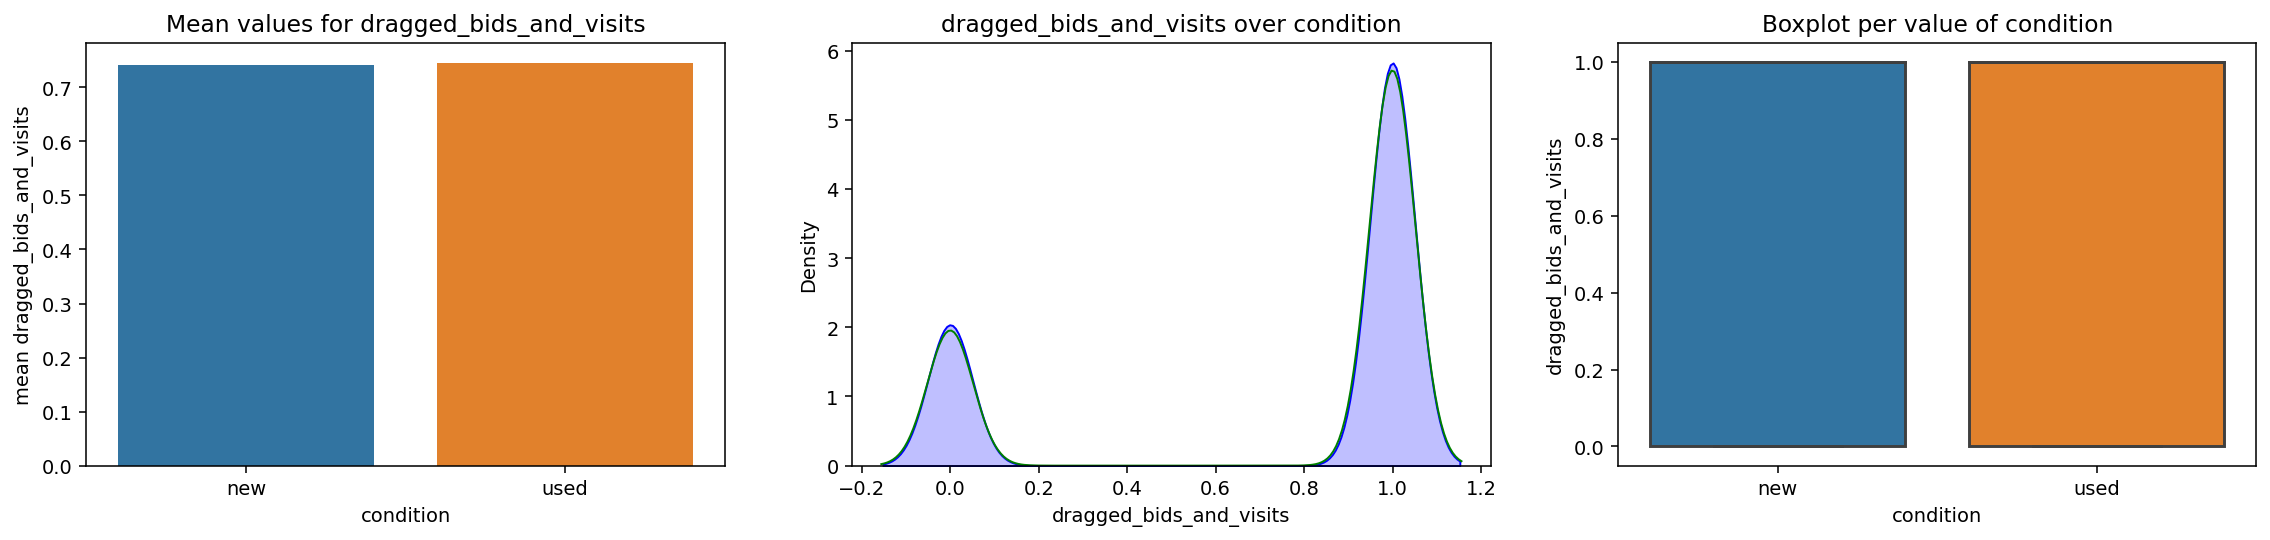

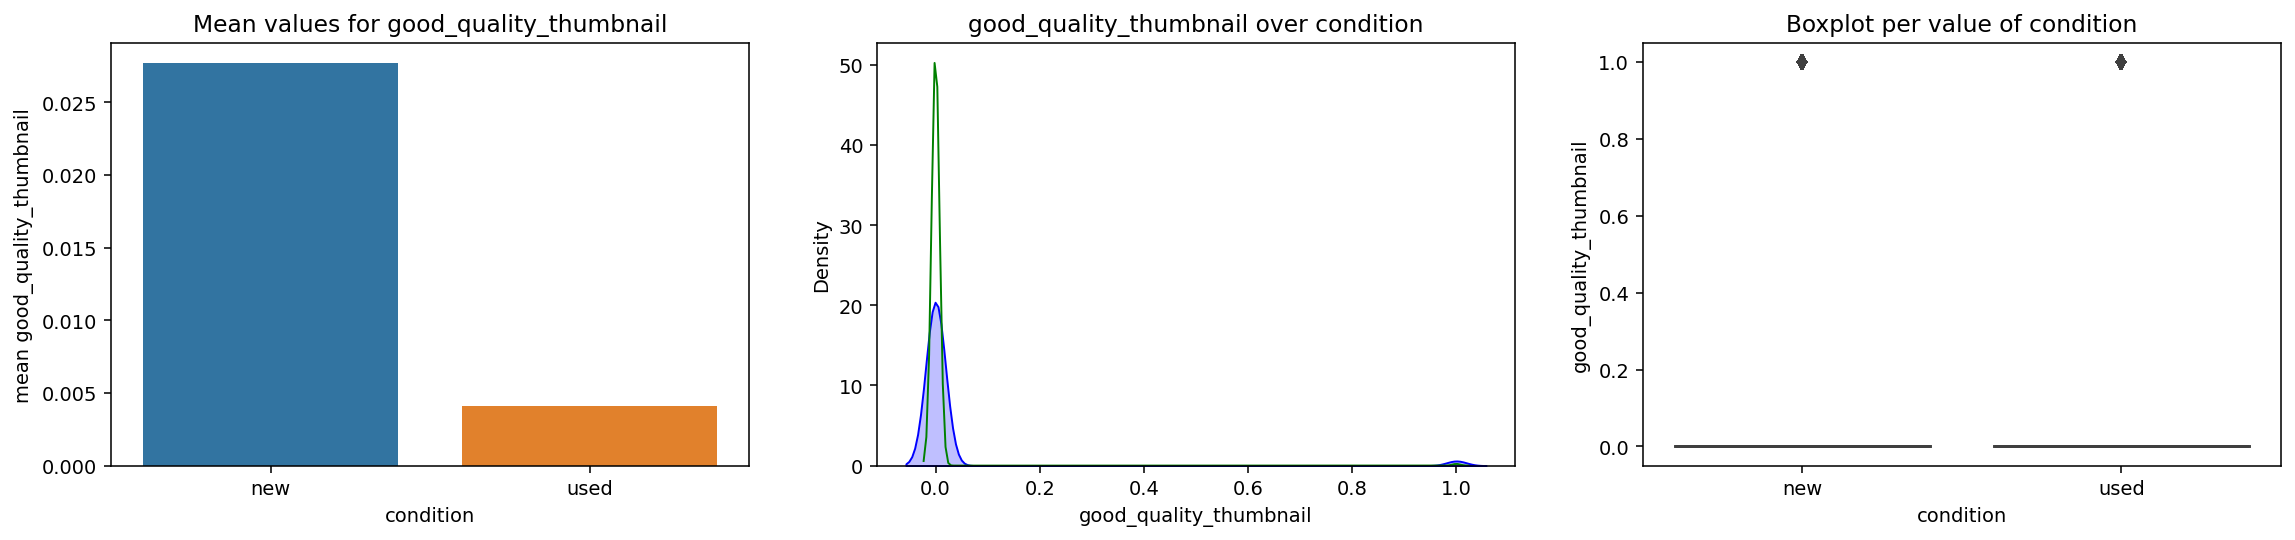

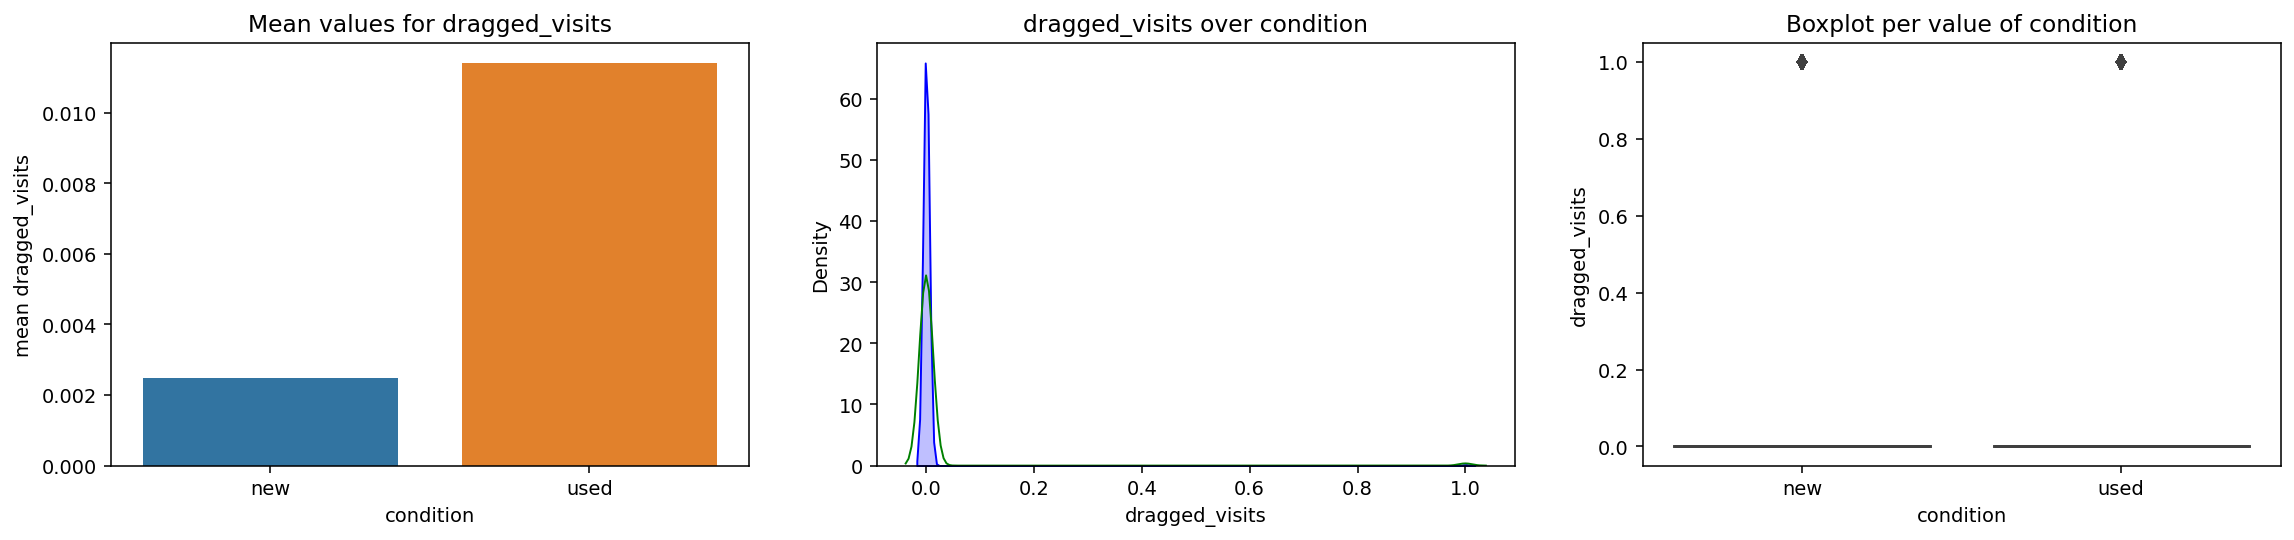

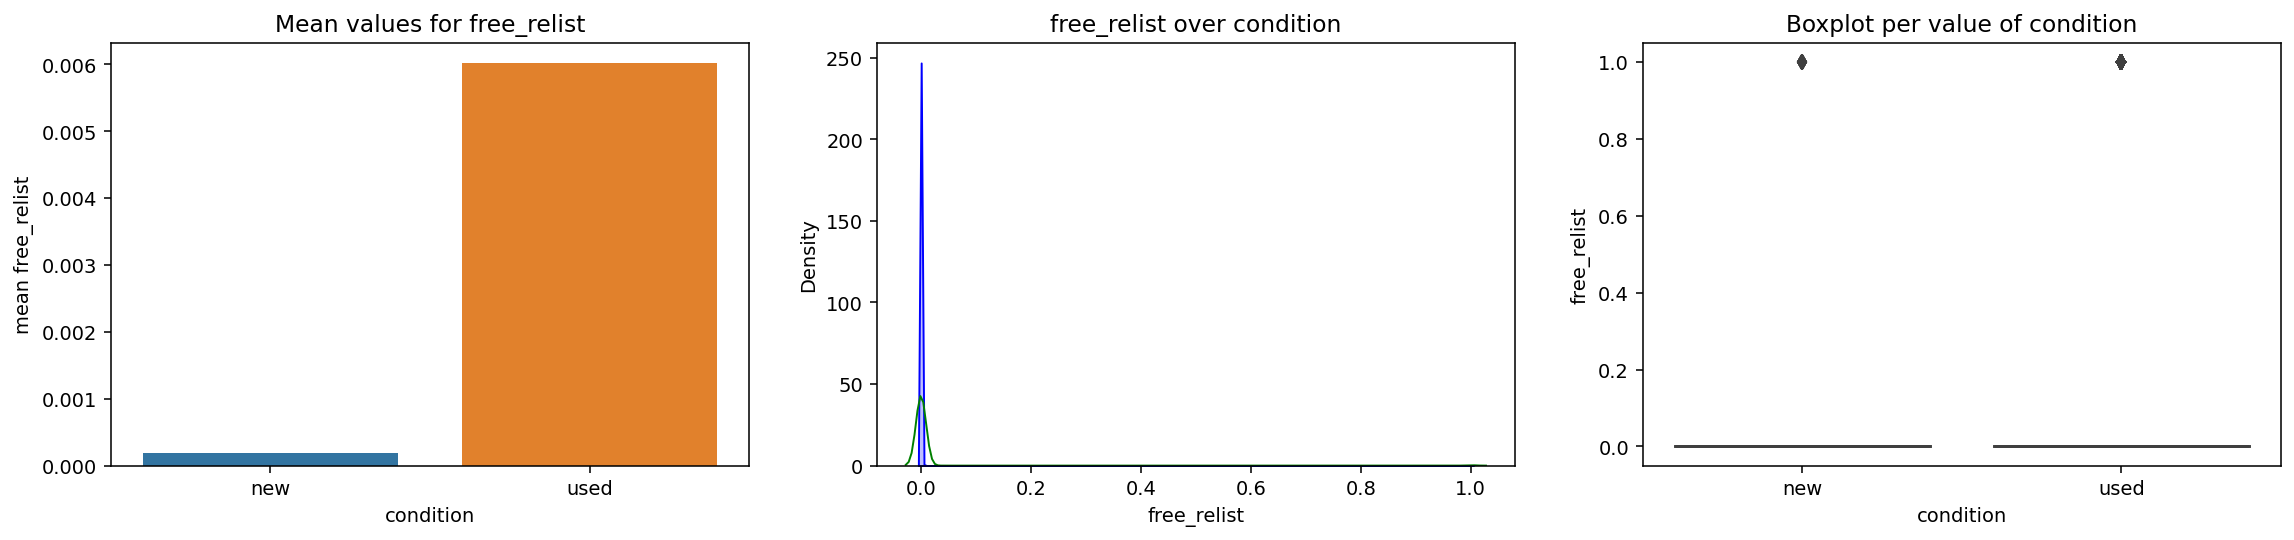

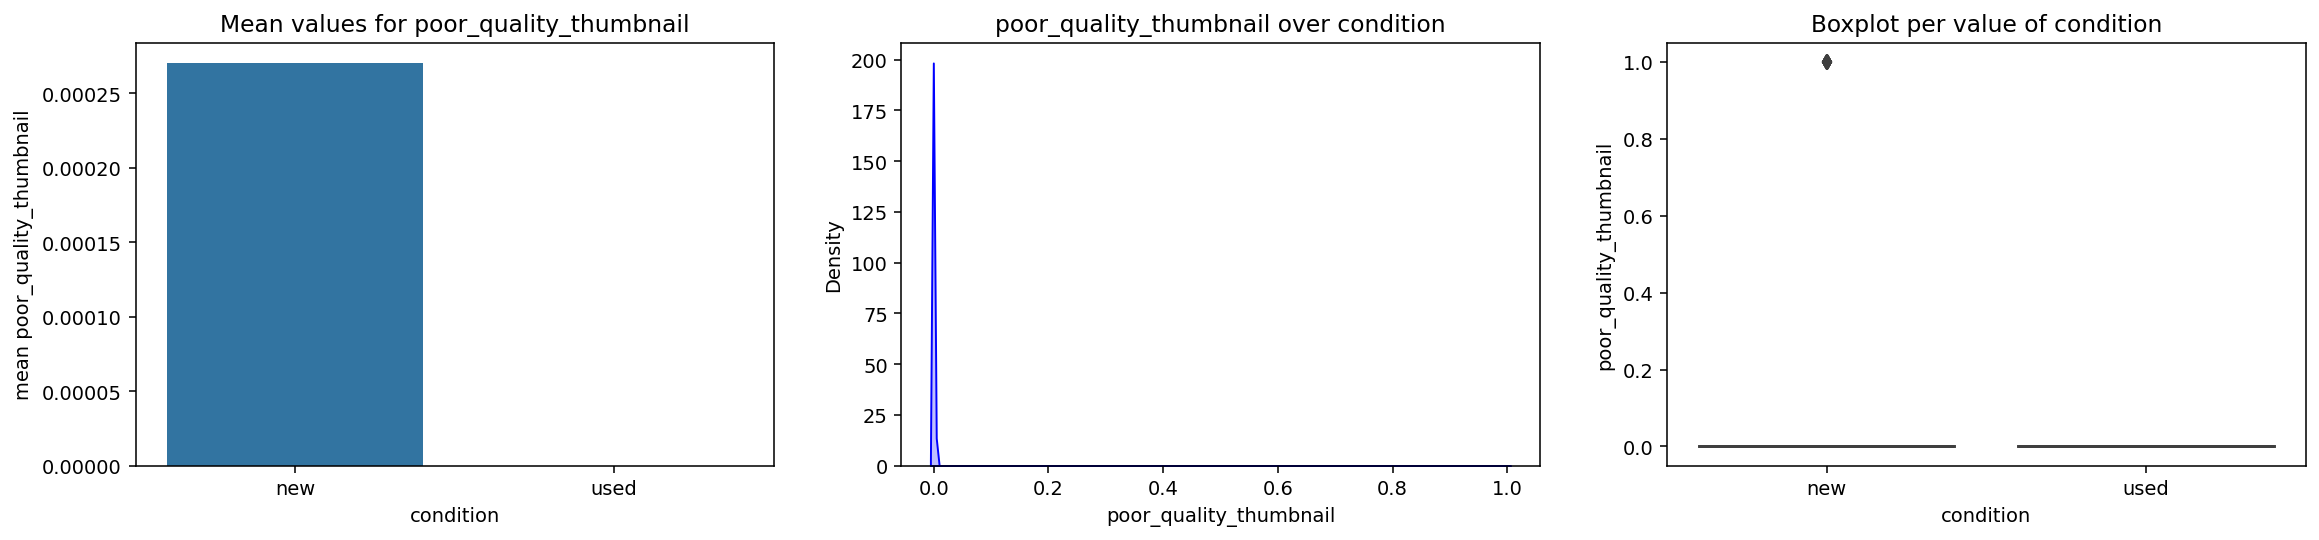

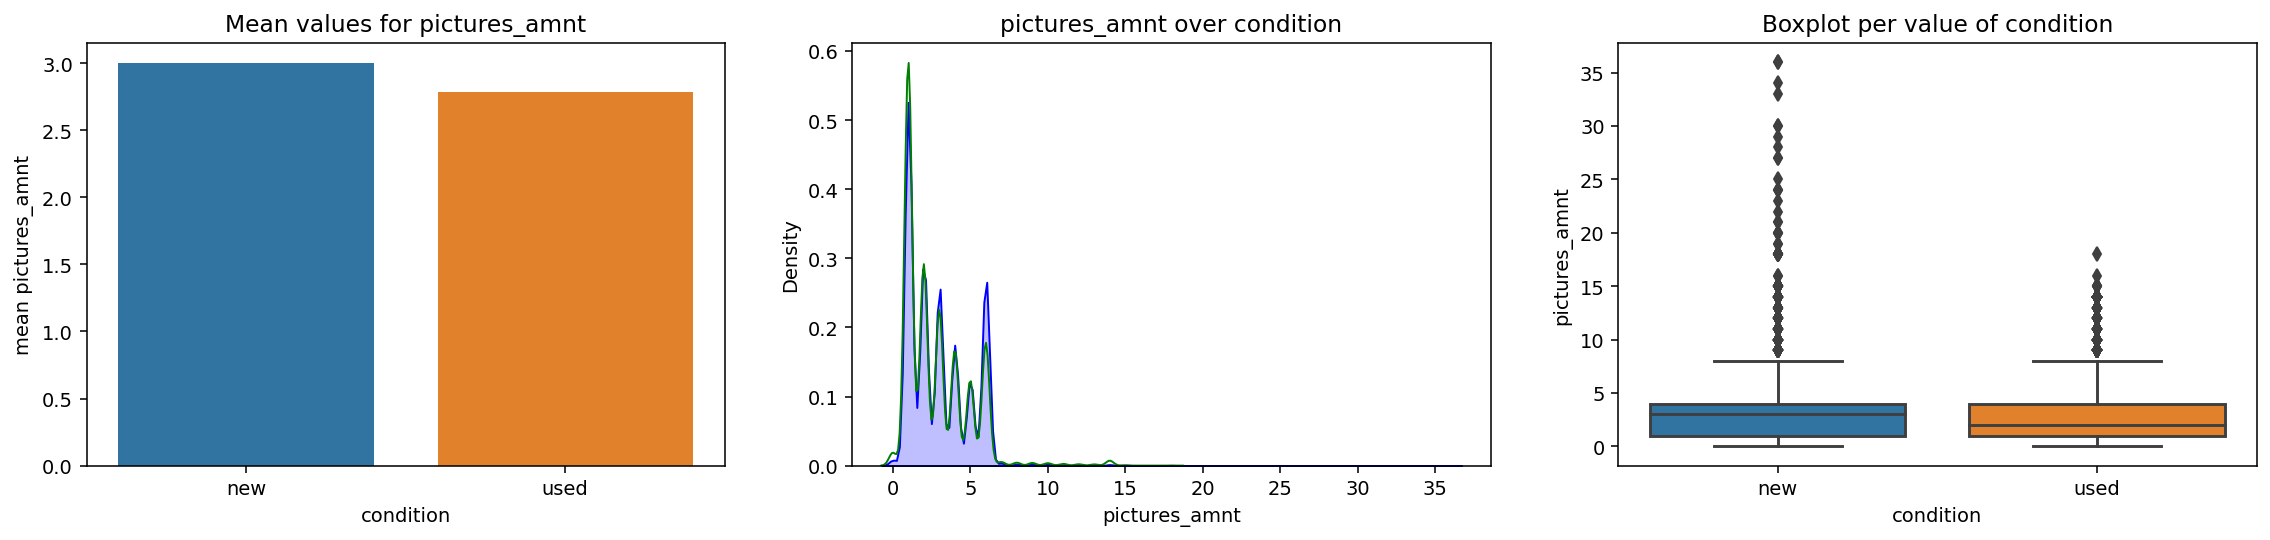

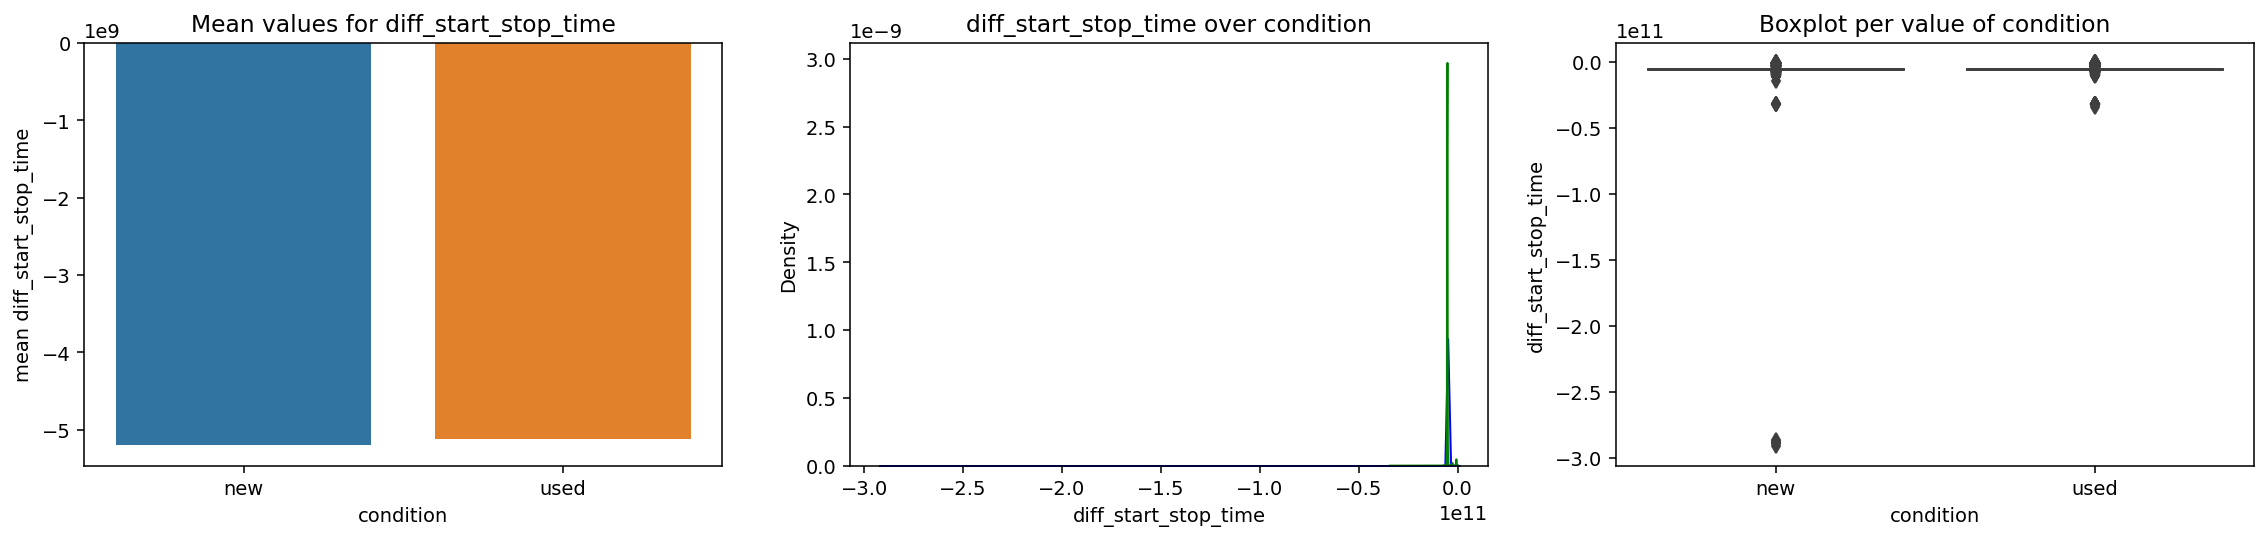

In [59]:
plt.rcParams.update({'figure.max_open_warning': 0})

for col in X_train.select_dtypes([np.number]).columns:
    eda.bivariate_numerical_categorical(X_train, col, 'condition', 'new', 'used')

- Let's drop columns with high p-value in both t-test and z-test

In [60]:
print(list(X_train))

['condition', 'base_price', 'listing_type_id', 'last_updated', 'accepts_mercadopago', 'automatic_relist', 'date_created', 'initial_quantity', 'sold_quantity', 'shipping.local_pick_up', 'shipping.free_shipping', 'shipping.mode', 'create_update_diff_days', 'MLATB', 'MLAWC', 'MLAMO', 'MLAOT', 'MLAMC', 'MLACD', 'MLADC', 'MLAWT', 'MLAMP', 'MLABC', 'variations_count', 'has_attributes', 'dragged_bids_and_visits', 'good_quality_thumbnail', 'dragged_visits', 'free_relist', 'poor_quality_thumbnail', 'pictures_amnt', 'diff_start_stop_time']


In [61]:
#X_train = X_train.drop(['base_price', 'accepts_mercadopago',
#                        'shipping.local_pick_up', 'MLAMC',
#                        'MLACD', 'MLADC',
#                        'dragged_bids_and_visits'], axis=1)

- Drop datetime columns since we don't need them anymore

In [62]:
X_train = X_train.drop(['last_updated', 'date_created'], axis=1)

- Let's make dummies out of `listing_type_id` and `shipping.mode`

In [63]:
X_train = pd.get_dummies(X_train, columns=['listing_type_id', 'shipping.mode'])

- Finally, drop the target/class column

In [64]:
X_train = X_train.drop(['condition'], axis=1)

- And check current dataframe

In [65]:
print(list(X_train))

['base_price', 'accepts_mercadopago', 'automatic_relist', 'initial_quantity', 'sold_quantity', 'shipping.local_pick_up', 'shipping.free_shipping', 'create_update_diff_days', 'MLATB', 'MLAWC', 'MLAMO', 'MLAOT', 'MLAMC', 'MLACD', 'MLADC', 'MLAWT', 'MLAMP', 'MLABC', 'variations_count', 'has_attributes', 'dragged_bids_and_visits', 'good_quality_thumbnail', 'dragged_visits', 'free_relist', 'poor_quality_thumbnail', 'pictures_amnt', 'diff_start_stop_time', 'listing_type_id_bronze', 'listing_type_id_free', 'listing_type_id_gold', 'listing_type_id_gold_premium', 'listing_type_id_gold_pro', 'listing_type_id_gold_special', 'listing_type_id_silver', 'shipping.mode_custom', 'shipping.mode_me1', 'shipping.mode_me2', 'shipping.mode_not_specified']


In [66]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89433 entries, 0 to 89432
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   base_price                    89433 non-null  float64
 1   accepts_mercadopago           89433 non-null  int64  
 2   automatic_relist              89433 non-null  int64  
 3   initial_quantity              89433 non-null  int64  
 4   sold_quantity                 89433 non-null  int64  
 5   shipping.local_pick_up        89433 non-null  int64  
 6   shipping.free_shipping        89433 non-null  int64  
 7   create_update_diff_days       89433 non-null  int64  
 8   MLATB                         89433 non-null  int64  
 9   MLAWC                         89433 non-null  int64  
 10  MLAMO                         89433 non-null  int64  
 11  MLAOT                         89433 non-null  int64  
 12  MLAMC                         89433 non-null  int64  
 13  M

In [67]:
y_train = y_train.map({'new': 1, 'used': 0}).values